In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import pickle as pk
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from os import path
import sys
from mmctools.plotting import TaylorDiagram
from scipy.stats import pearsonr
import glob
from mmctools.wrf.utils import tsout_seriesReader
from matplotlib.colors import Normalize
from string import ascii_lowercase

# Case specifics:

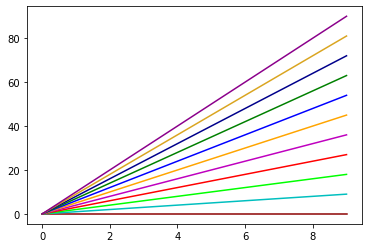

In [3]:
#main_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/'
main_directory = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/'

icbc_type = 'MERRA2'  # ERAI, ERA5, FNL

from NYSERDA_case_dict import case_dict

cases = [case_dict[x]['case_str'] for x in list(case_dict.keys())]

eta_level_testing = False
if eta_level_testing:
    main_directory += 'eta_level_test/'
    cases = cases[-3:]
    time_step = 5.0
else:
    cases = cases[:]
    failed_cases = []
    for case in failed_cases:
        cases.remove(case)
    time_step = 6.0

sim_start = '2020-04-04 06:00:00'
case_start = '2020-04-05 16:00:00'
case_end   = '2020-04-06 06:00:00'
#case_end   = '2020-04-06 12:00:00'
best_case  = 'WPS3_WRF1'
n_profiles = 8

for cc,case in enumerate(cases):
    plt.plot(np.arange(0,10),np.arange(0,10)*cc,c=case_dict[case]['color'])

# Domains:

In [4]:
wrfin_list = sorted(glob.glob('{}{}/wrfin*'.format(main_directory,cases[0])))
wrfin_dict = {}
for ff,wrfin_f in enumerate(wrfin_list):
    wrfin_dict['d0{}'.format(ff+1)] = xr.open_dataset(wrfin_f).squeeze()
    

In [5]:
def labelAtEdge(levels, cs, ax, fmt, side='both', pad=0.005, **kwargs):
    '''Label contour lines at the edge of plot
    Args:
        levels (1d array): contour levels.
        cs (QuadContourSet obj): the return value of contour() function.
        ax (Axes obj): matplotlib axis.
        fmt (str): formating string to format the label texts. E.g. '%.2f' for
            floating point values with 2 demical places.
    Keyword Args:
        side (str): on which side of the plot intersections of contour lines
            and plot boundary are checked. Could be: 'left', 'right', 'top',
            'bottom' or 'all'. E.g. 'left' means only intersections of contour
            lines and left plot boundary will be labeled. 'all' means all 4
            edges.
        pad (float): padding to add between plot edge and label text.
        **kwargs: additional keyword arguments to control texts. E.g. fontsize,
            color.
    '''
    from matplotlib.transforms import Bbox
    collections = cs.collections
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    bbox = Bbox.from_bounds(xlim[0], ylim[0], xlim[1]-xlim[0], ylim[1]-ylim[0])
    eps = 1e-5  # error for checking boundary intersection
    # -----------Loop through contour levels-----------
    for ii, lii in enumerate(levels):
        cii = collections[ii]  # contours for level lii
        pathsii = cii.get_paths()  # the Paths for these contours
        if len(pathsii) == 0:
            continue
        for pjj in pathsii:
            # check first whether the contour intersects the axis boundary
            if not pjj.intersects_bbox(bbox, False):  # False significant here
                continue
            xjj = pjj.vertices[:, 0]
            yjj = pjj.vertices[:, 1]
            # intersection with the left edge
            if side in ['left', 'all']:
                inter_idx = np.where(abs(xjj-xlim[0]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x-pad, inter_y, fmt % lii,
                            ha='right',
                            va='center',
                            **kwargs)
            # intersection with the right edge
            if side in ['right', 'all']:
                inter_idx = np.where(abs(xjj-xlim[1]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x+pad, inter_y, fmt % lii,
                            ha='left',
                            va='center',
                            **kwargs)
            # intersection with the bottom edge
            if side in ['bottom', 'all']:
                inter_idx = np.where(abs(yjj-ylim[0]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x, inter_y-pad, fmt % lii,
                            ha='center',
                            va='top',
                            **kwargs)
            # intersection with the top edge
            if side in ['top', 'all']:
                inter_idx = np.where(abs(yjj-ylim[-1]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x, inter_y+pad, fmt % lii,
                            ha='center',
                            va='bottom',
                            **kwargs)
    return

def domain_plot(axi,domain_s,domain_e,number_lat_ticks=6,number_lon_ticks=6):
    pgr = 1
    i_s,j_s = 0,0
    for dom in range(domain_s,+domain_e+1):
        wrf_lat = wrfin_dict['d0{}'.format(dom)].XLAT
        wrf_lon = wrfin_dict['d0{}'.format(dom)].XLONG
        wrf_hgt = wrfin_dict['d0{}'.format(dom)].HGT
        wrf_sst = wrfin_dict['d0{}'.format(dom)].SST
        wrf_landmask = wrfin_dict['d0{}'.format(dom)].LANDMASK

        if dom == domain_s:
            min_lat = float(np.round(wrf_lat.min()))
            max_lat = float(wrf_lat.max())
            lat_span = max_lat - min_lat
            
            min_lon = float(np.round(wrf_lon.min()))
            max_lon = float(wrf_lon.max())
            lon_span = max_lon - min_lon
            
            if (lon_span < 10.0) or (lat_span < 10.0):
                num_dec = 1
            else:
                num_dec = 0
                
            lat_int = np.round(lat_span / number_lat_ticks, decimals=num_dec)
            lon_int = np.round(lon_span / number_lon_ticks,decimals=num_dec)

            #plt.contourf(wrf_hgt.where(wrf_landmask==1.0),cmap=plt.cm.terrain,alpha=0.25)
            #plt.contourf(wrf_sst.where(wrf_landmask==0.0),cmap=plt.cm.viridis,alpha=0.5,linewidths=None)
            axi.contourf(wrf_landmask,colors='lightgreen',levels=[0.5,1.0],alpha=0.5)
            axi.contourf(wrf_landmask,colors='lightskyblue',levels=[0.0,0.5],alpha=0.5)
            axi.contour(wrf_landmask,colors='grey',levels=[0.5],alpha=0.5)
            lat_cs = axi.contour(wrf_lat,levels=np.arange(min_lat,max_lat,lat_int),
                                 colors='k',alpha=0.25)

            lon_cs = axi.contour(wrf_lon,levels=np.arange(min_lon,max_lon,lon_int),
                                 colors='k',alpha=0.25,linestyles='solid')
            lat_levels = lat_cs.levels
            lon_levels = lon_cs.levels

            axi.tick_params(left=False,bottom=False,labelsize=0)
            labelAtEdge(lat_levels, lat_cs, axi, r'%.1f', side='left', pad=2,size=16)
            labelAtEdge(lon_levels, lon_cs, axi, r'%.1f', side='bottom', pad=5,size=16)
            axi.set_ylabel('Latitude',size=18,labelpad=40)
            axi.set_xlabel('Longitude',size=18,labelpad=20)
            axi.set_aspect('equal')

        else:
            i_s += wrfin_dict['d0{}'.format(dom)].I_PARENT_START/pgr
            j_s += wrfin_dict['d0{}'.format(dom)].I_PARENT_START/pgr
            pgr *= wrfin_dict['d0{}'.format(dom)].PARENT_GRID_RATIO

            n_x = len(wrfin_dict['d0{}'.format(dom)].west_east)/pgr
            n_y = len(wrfin_dict['d0{}'.format(dom)].south_north)/pgr

            dom_x = [i_s,i_s+n_x,i_s+n_x,i_s,i_s]
            dom_y = [j_s,j_s,j_s+n_y,j_s+n_y,j_s]
            axi.plot(dom_x,dom_y,c='k')
            axi.text((2*i_s+n_x)*0.5,j_s+n_y+5,'d0{}'.format(dom),size=18,ha='center')



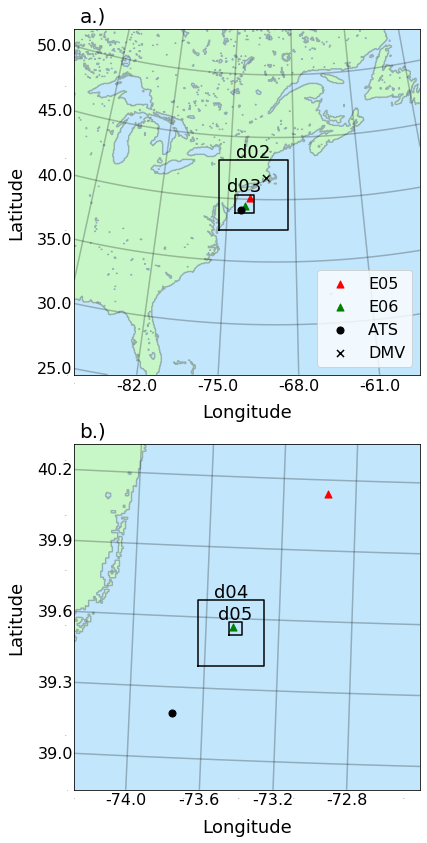

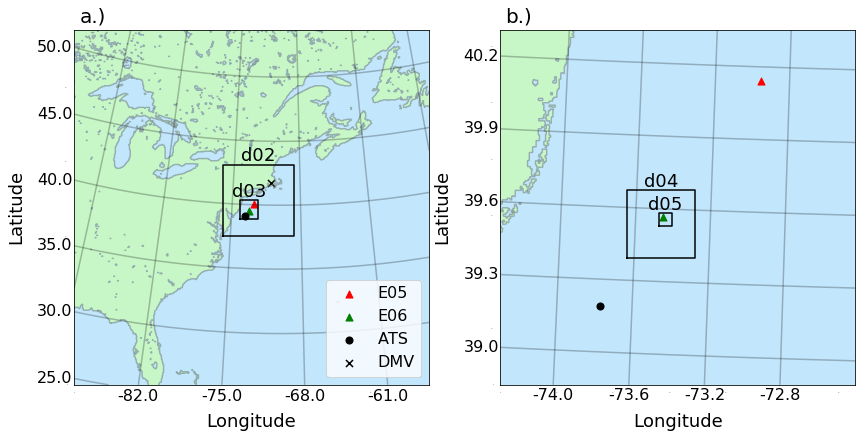

In [6]:
for fig_type in ['vert','horz']:

    if fig_type == 'vert':
        nrows = 2
        ncols = 1
        figsize = (7,14)
    else:
        nrows = 1
        ncols = 2
        figsize = (14,7)

        
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    domain_plot(ax[0],1,3)
    domain_plot(ax[1],3,5,number_lat_ticks=5,number_lon_ticks=4)
    ax[0].text(0.015,1.01,'a.)',size=20,transform=ax[0].transAxes,ha='left',va='bottom')#,bbox={'fc':'w','ec':'none'})
    ax[1].text(0.015,1.01,'b.)',size=20,transform=ax[1].transAxes,ha='left',va='bottom')#,bbox={'fc':'w','ec':'none'})

    twr_lat = [ 39.969278,  39.546772,  39.2717,  41.325567]
    twr_lon = [-72.716692, -73.428892, -73.8892, -70.568883]
    twr_names = ['E05','E06','Atlantic Shores','DOE_MV']
    twr_abbreviation = ['E05','E06','ATS','DMV']
    twr_colors = ['r','g','k','k']
    twr_markers = ['^','^','o','x']

    for axi in range(0,2):
        for tt,twr in enumerate(twr_abbreviation):
            wrf_lat = wrfin_dict['d0{}'.format(axi*2 + 1)].XLAT
            wrf_lon = wrfin_dict['d0{}'.format(axi*2 + 1)].XLONG
            dist = ((twr_lat[tt]-wrf_lat)**2 + (twr_lon[tt]-wrf_lon)**2)**0.5

            min_dist = np.nanmin(dist)
            if min_dist < 0.1:
                twrj,twri = np.where(dist==np.nanmin(dist))
                ax[axi].scatter(twrj+0.5,twri+0.5,c=twr_colors[tt],
                                marker=twr_markers[tt],s=50,
                                label=twr)

    ax[0].legend(loc=4,fontsize=16)
    plt.show()


In [7]:
def get_cases_of_interest(cases,case_selection):
    if case_selection == 'SST':
        cases_of_interest = ['MERRA2_DFLT_NOSK_CHRN_MDIS']
        for case in cases:
            if case.split('_')[1] != 'DFLT':
                cases_of_interest.append(case)
    elif case_selection == 'SFC':
        cases_of_interest = []
        for case in cases:
            if case.split('_')[1] == 'DFLT':
                if case.split('_')[-1] == 'MDIS':
                    cases_of_interest.append(case)
            if case.split('_')[-1] == 'USGS':
                cases_of_interest.append(case)
    elif case_selection == 'LANDUSE':
        cases_of_interest = ['MERRA2_DFLT_NOSK_CHRN_MDIS']
        for case in cases:
            if case.split('_')[-1] == 'USGS':
                cases_of_interest.append(case)
    return(cases_of_interest)

# Get obs:

In [8]:
obs_dir = '/glade/work/hawbecke/MMC/NYSERDA/obs/'
nyserda_full = xr.open_dataset('{}NYSERDA_lidars.nc'.format(obs_dir))
atlshrs_full = xr.open_dataset('{}ATLSHORES_lidars.nc'.format(obs_dir))

nyserda_obs = nyserda_full.sel(case='obs')
atlshrs_obs = atlshrs_full.sel(case='obs')

best_case = 'WPS3_WRF1'
nyserda_opt = nyserda_full.sel(case=best_case)
atlshrs_opt = atlshrs_full.sel(case=best_case)

# Get WRF:

In [9]:
wrf_data = {}
restarts = ['']
for cc,case in enumerate(cases):
    print(case)
    tower_f = '{0}{1}/NYSERDA_{1}_towers_d02.nc'.format(main_directory,case)

    print(tower_f)
    sim_start = '2020-04-04 06:00:00'



    
    if '131_levels' in case:
        time_step = 4.0
    else:
        time_step = 5.0
        
        
        
        
    if path.exists(tower_f):
        wrf_data[case] = xr.open_dataset(tower_f)
    else:
        print('{}{}/'.format(main_directory,case))
        tower_dat = tsout_seriesReader(fdir='{}{}/'.format(main_directory,case),
                                       restarts=restarts,
                                       simulation_start_time=sim_start,
                                       domain_of_interest='d02',
                                       time_step=time_step,
                                       structure='unordered')
        tower_dat.to_netcdf(tower_f)
        wrf_data[case] = tower_dat

MERRA2_DFLT_NOSK_CHRN_MDIS
/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/MERRA2_DFLT_NOSK_CHRN_MDIS/NYSERDA_MERRA2_DFLT_NOSK_CHRN_MDIS_towers_d02.nc
MERRA2_CMCS_NOSK_CHRN_MDIS
/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/MERRA2_CMCS_NOSK_CHRN_MDIS/NYSERDA_MERRA2_CMCS_NOSK_CHRN_MDIS_towers_d02.nc
MERRA2_OSPO_NOSK_CHRN_MDIS
/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/MERRA2_OSPO_NOSK_CHRN_MDIS/NYSERDA_MERRA2_OSPO_NOSK_CHRN_MDIS_towers_d02.nc
MERRA2_MURS_NOSK_CHRN_MDIS
/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/MERRA2_MURS_NOSK_CHRN_MDIS/NYSERDA_MERRA2_MURS_NOSK_CHRN_MDIS_towers_d02.nc
MERRA2_NAVO_NOSK_CHRN_MDIS
/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/MERRA2_NAVO_NOSK_CHRN_MDIS/NYSERDA_MERRA2_NAVO_NOSK_CHRN_MDIS_towers_d02.nc
MERRA2_OSTI_NOSK_CHRN_MDIS
/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/MERRA2_OSTI_NOSK_CHRN_MDIS/NYSERDA_MERRA2_OSTI_NOSK_CHRN_MDIS_towers_d02.nc
MERRA2_GO16_NOSK_CHRN_MDIS
/glade/work/hawbecke/MMC/

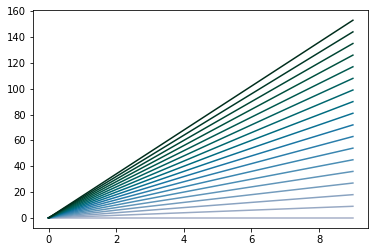

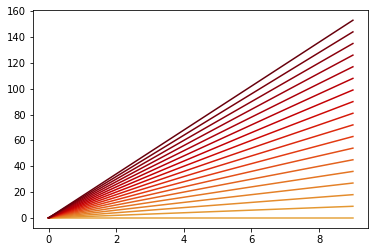

In [10]:
Ulvl_colors = {}
Ulevels = nyserda_obs.Ulevels.data
for ss,lvl in enumerate(Ulevels):
    line_cols = plt.cm.PuBuGn(np.linspace(0.3,1.0,len(Ulevels)))[ss]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    Ulvl_colors[lvl] = line_cols
for ss,lvl in enumerate(Ulevels):
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=Ulvl_colors[lvl])
plt.show()

Tlvl_colors = {}
Tlevels = nyserda_obs.Tlevels.data
for ss,lvl in enumerate(Tlevels):
    line_cols = plt.cm.YlOrRd(np.linspace(0.3,1.0,len(Tlevels)))[ss]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    Tlvl_colors[lvl] = line_cols
for ss,lvl in enumerate(Ulevels):
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=Tlvl_colors[lvl])
plt.show()

# Resample WRF to Obs times / heights:

In [11]:
profile_times = pd.date_range(case_start,case_end,periods=n_profiles)
time_colors = {}
for pp,pt in enumerate(profile_times):
    line_cols = plt.cm.jet(np.linspace(0.10,0.9,n_profiles))[pp]
    darken = 0.2
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    time_colors[pt] = line_cols

data_ds_fname = '{}resampled_data_obs_and_WRF.nc'.format(main_directory)
    
if path.exists(data_ds_fname):
    print('Loading in {}'.format(data_ds_fname))
    data_ds = xr.open_dataset(data_ds_fname)
else:
    print('Resampling WRF and packaging into {}'.format(data_ds_fname))
    init_wspd_da = True
    good_wrf_lvls = {}
    for dd,lid in enumerate(nyserda_obs.lidar.data):
        good_wrf_lvls[lid] = {}
        for cc,case in enumerate(cases[:]):
            print(case)
            good_wrf_lvls[lid][case] = []

            nyserda_obs_case = nyserda_obs.sel(datetime=slice(case_start,case_end))
            good_levels = []

            wrf_data_res = wrf_data[case].resample({'datetime':'10min'}).mean().sel(
                                                    datetime=slice(case_start,case_end))

            wrf_levels = wrf_data_res.ph.mean(dim='datetime').sel(station=lid)

            for lvl in nyserda_obs.Ulevels.data:
                wspd_obs = nyserda_obs_case.wspd.sel(lidar=lid,Ulevels=lvl,
                                                     datetime=slice(case_start,case_end))
                if len(wspd_obs.dropna(how='any',dim='datetime')) > 1:
                    data_ds_0 = wspd_obs.assign_coords({'level':lvl,'case':'obs'}
                                       ).expand_dims({'level':1,'case':1,'lidar':1}
                                       ).drop(['Ulevels']).to_dataset()
                    data_ds_0['wrf_level'] = xr.DataArray([[[np.nan]]],dims=['level','case','lidar'])
                    if init_wspd_da:
                        data_ds = data_ds_0.copy()
                        init_wspd_da = False
                    else:
                        data_ds = data_ds.combine_first(data_ds_0)

                    plot_this_level = True
                    good_levels.append(lvl)                    
                else:
                    plot_this_level = False

                level_dist = abs(wrf_levels - lvl)
                wrf_lvl_ind = int(np.where(level_dist == np.nanmin(level_dist))[0])
                if (level_dist[wrf_lvl_ind] <= 10.0) and plot_this_level:
                    wrf_lvl = float(wrf_levels[wrf_lvl_ind].data)
                    if wrf_lvl not in good_wrf_lvls[lid]:
                        good_wrf_lvls[lid][case].append(wrf_lvl)
                    wspd_wrf = wrf_data_res.wspd.sel(nz=wrf_lvl_ind,station=lid)
                    wspd_wrf[np.where(np.isnan(wspd_obs))] = np.nan
                    wrf_ds = wspd_wrf.rename({'station':'lidar'}
                                    ).assign_coords({'level':lvl,'case':case}
                                    ).expand_dims({'level':1,'case':1,'lidar':1}
                                    ).drop(['k','zsurface']).to_dataset()
                    wrf_ds['wrf_level'] = xr.DataArray([[[wrf_lvl]]],dims=['level','case','lidar'])
                    data_ds = data_ds.combine_first(wrf_ds)

            sst_ds = wrf_data_res.tsk.sel(station=lid).rename({'station':'lidar'}
                                    ).assign_coords({'case':case}
                                    ).expand_dims({'case':1,'lidar':1}
                                    ).drop(['zsurface'])
            sst_ds.name = 'sst'
            t2_ds = wrf_data_res.t2.sel(station=lid).rename({'station':'lidar'}
                                    ).assign_coords({'case':case}
                                    ).expand_dims({'case':1,'lidar':1}
                                    ).drop(['zsurface'])
            t2_ds.name = 't2'

            if cc == 0:
                obs_sst_ds = nyserda_obs_case.sst.sel(lidar=lid
                                               ).assign_coords({'case':'obs'}
                                               ).expand_dims({'case':1,'lidar':1}
                                               ).to_dataset()
                obs_t2_da = nyserda_obs_case.T.sel(lidar=lid,Tlevels=2
                                               ).assign_coords({'case':'obs'}
                                               ).expand_dims({'case':1,'lidar':1}
                                               ).drop(['Tlevels'])
                obs_t2_da.name = 't2'
                obs_t2_ds = obs_t2_da.to_dataset()
                sst_ds = obs_sst_ds.combine_first(sst_ds)
                t2_ds = obs_t2_ds.combine_first(t2_ds)
            data_ds = xr.merge((data_ds,sst_ds,t2_ds))
    data_ds.to_netcdf(data_ds_fname)


Loading in /glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/resampled_data_obs_and_WRF.nc


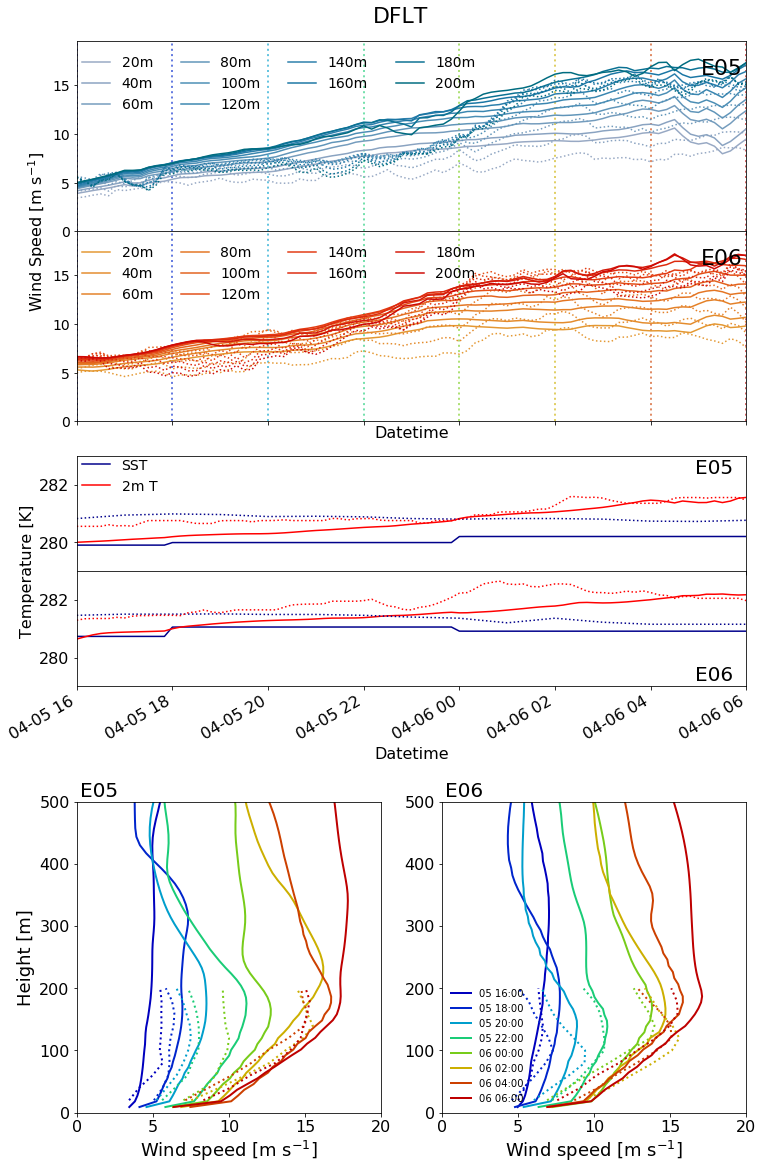

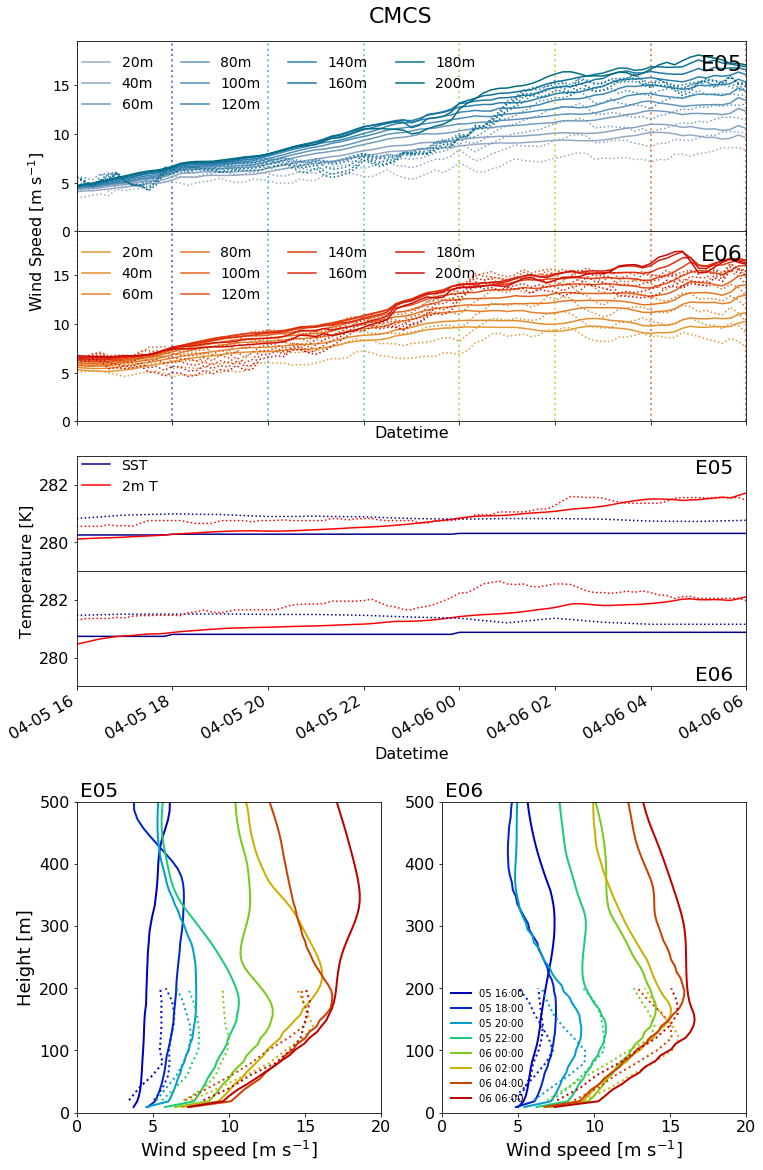

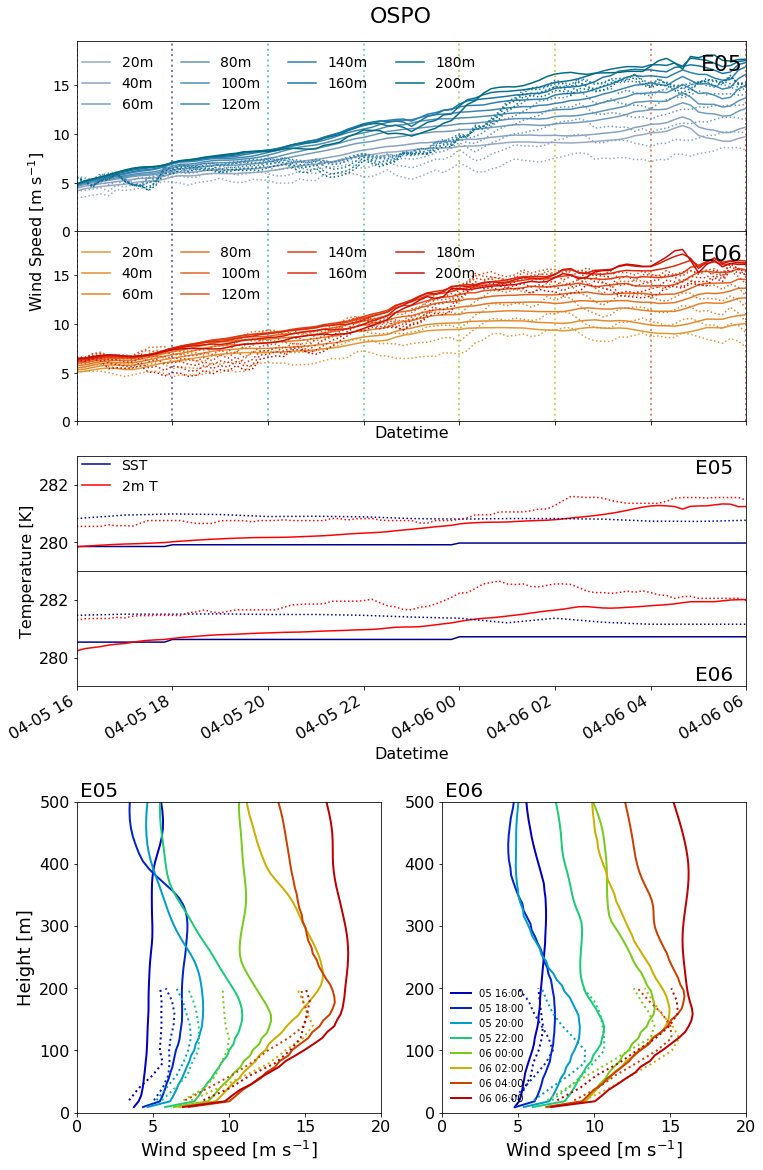

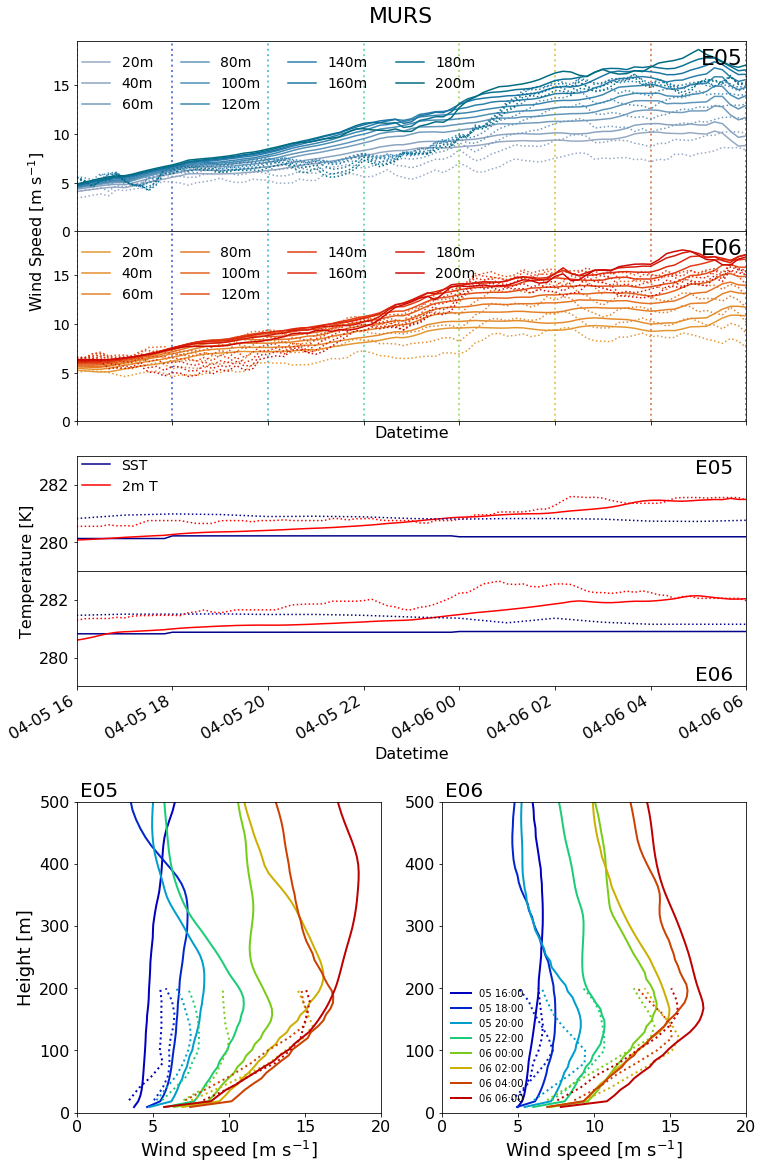

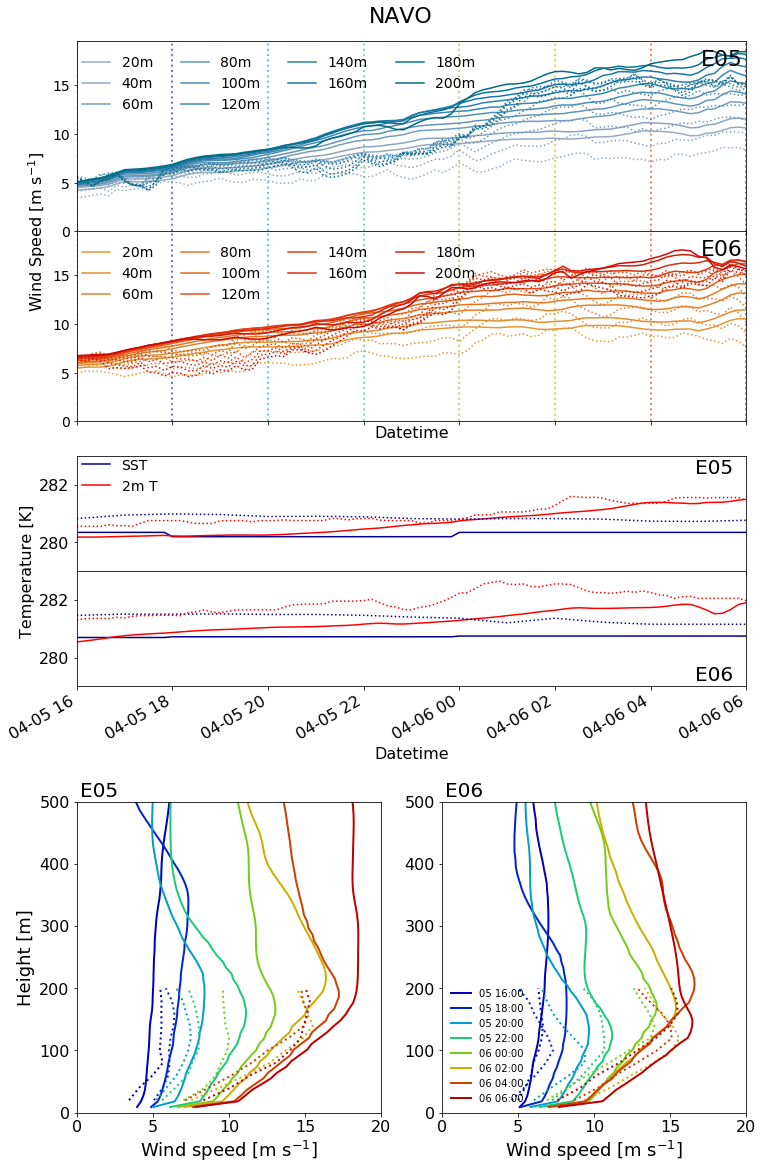

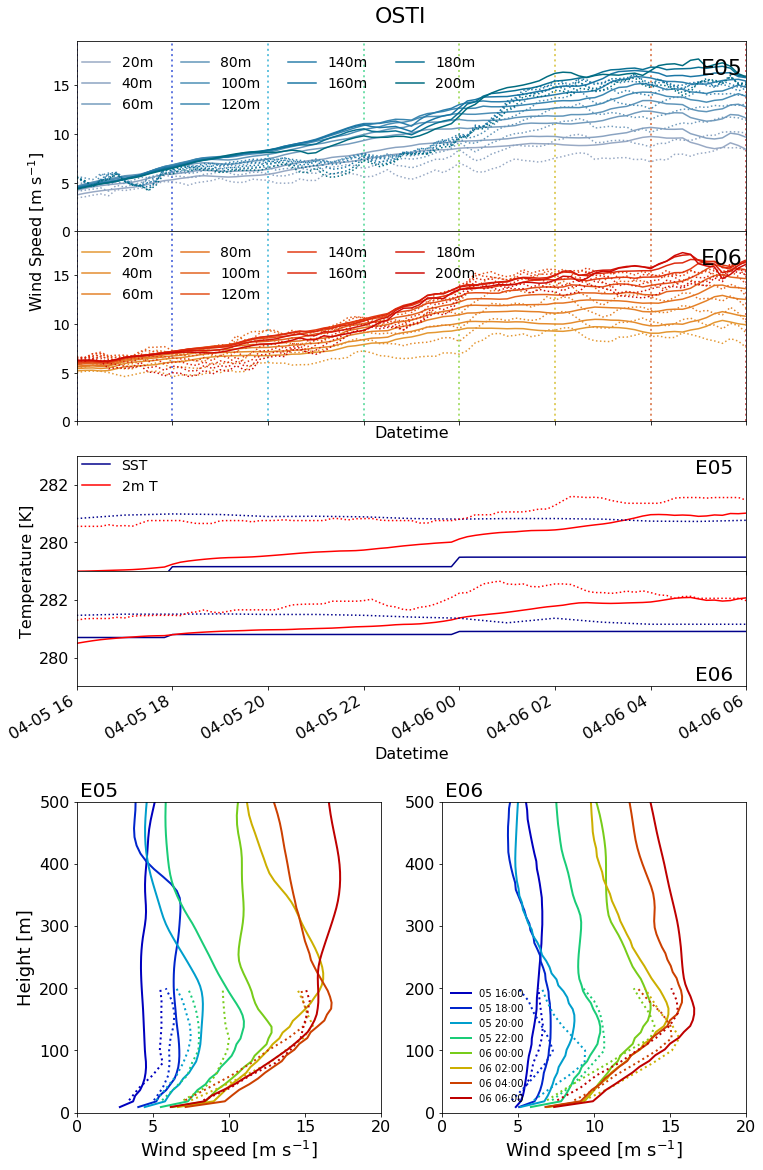

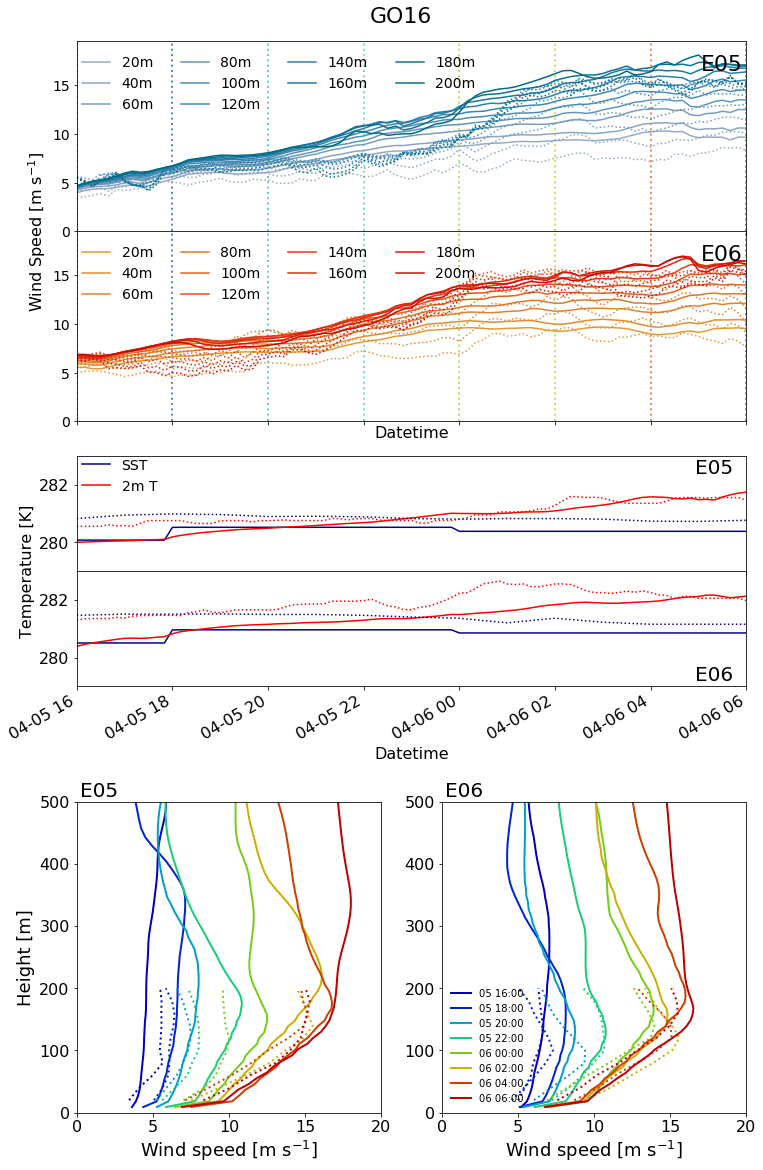

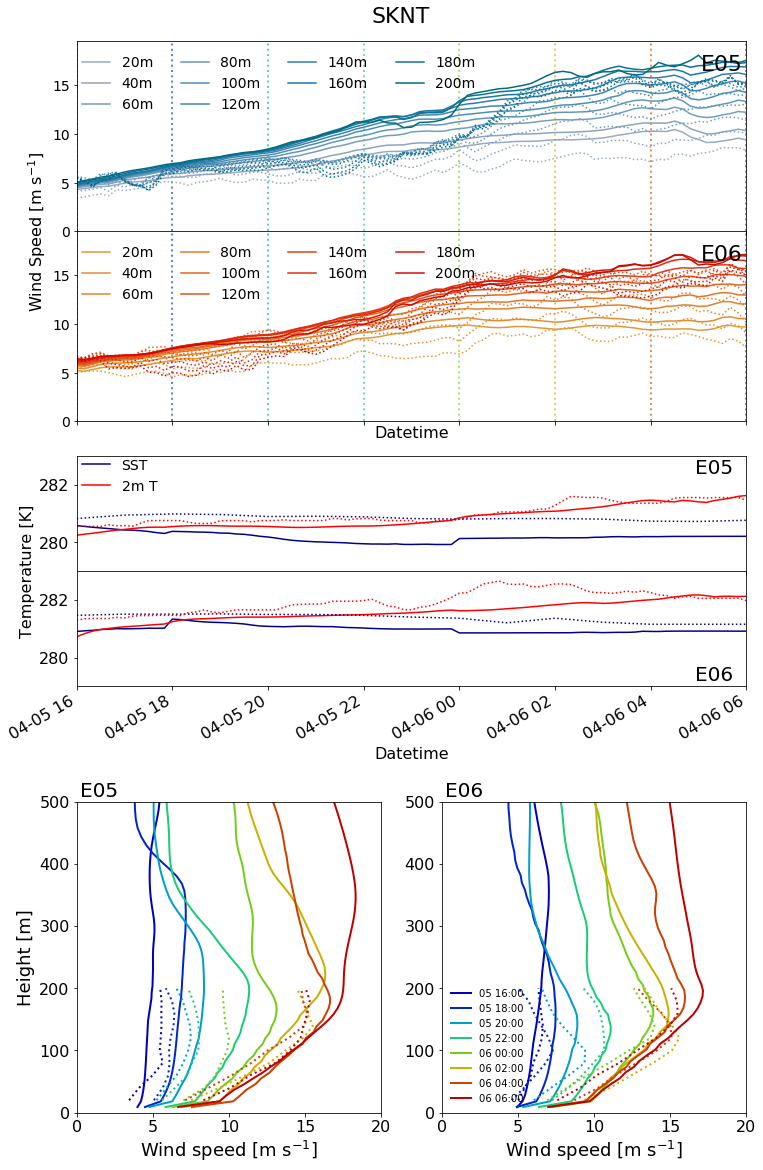

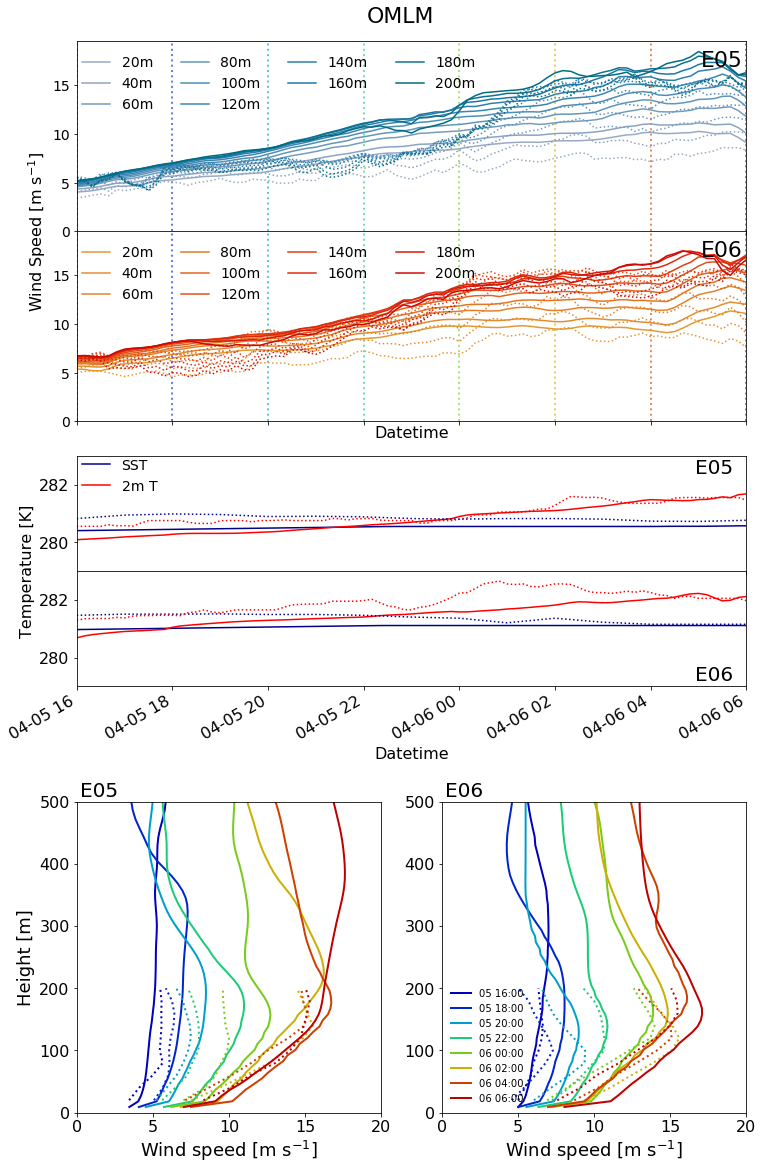

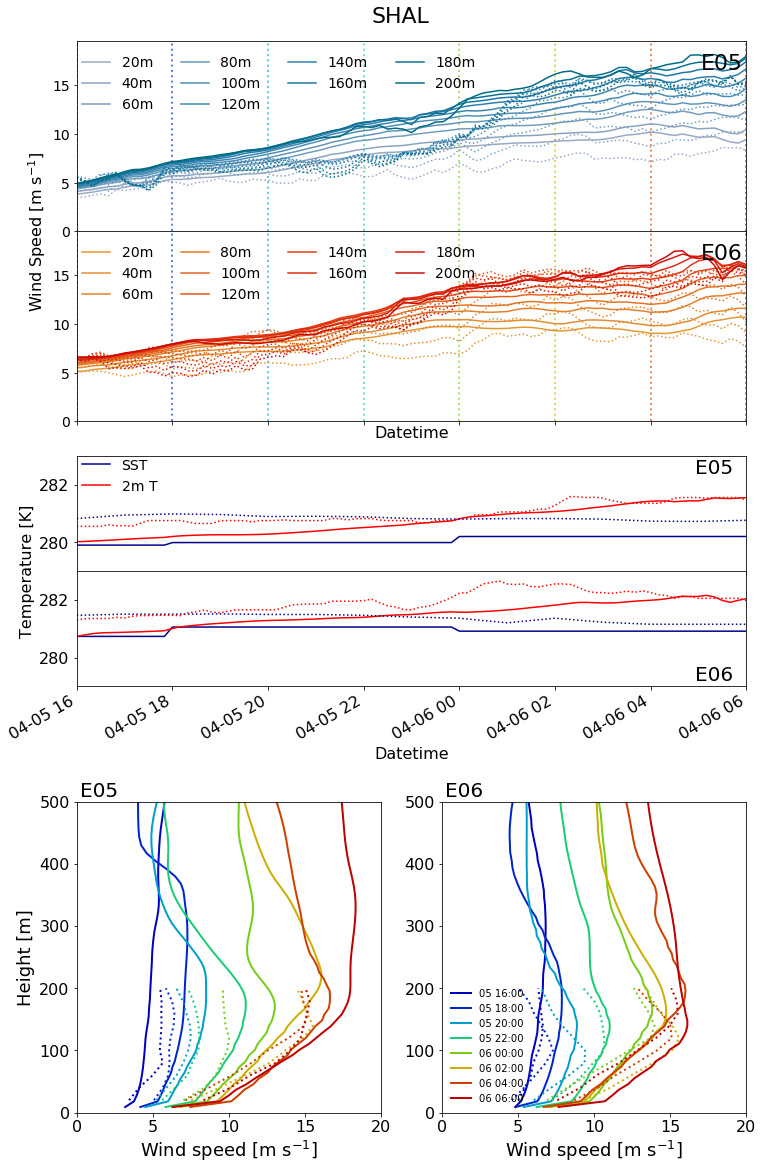

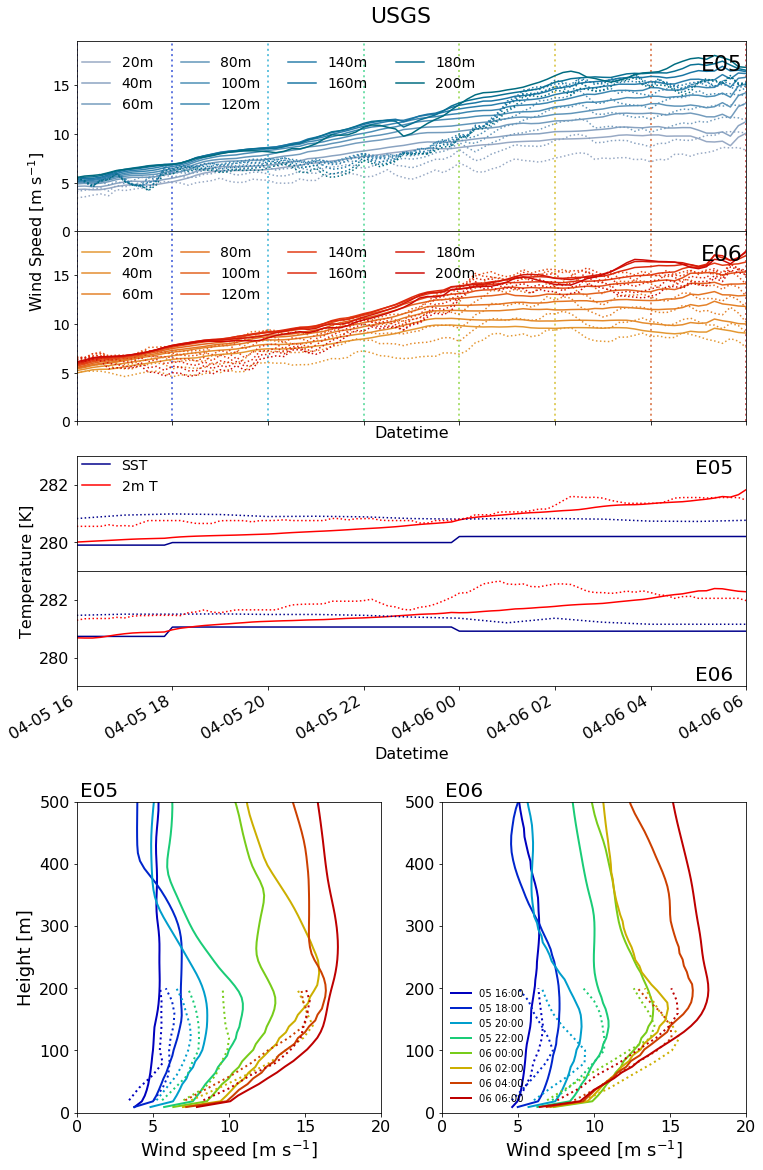

In [12]:
profile_times = pd.date_range(case_start,case_end,periods=n_profiles)
time_colors = {}
for pp,pt in enumerate(profile_times):
    line_cols = plt.cm.jet(np.linspace(0.10,0.9,n_profiles))[pp]
    darken = 0.2
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    time_colors[pt] = line_cols

for cc,case in enumerate(cases):
    fig = plt.figure(figsize=(12,16),constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=2, ncols=1, bottom=0.65, top=0.98,
                           hspace=0.0)
    e05_u = fig.add_subplot(gs1[0])
    e06_u = fig.add_subplot(gs1[1],sharex=e05_u,sharey=e05_u)
    
    for dd,lid in enumerate(nyserda_obs.lidar.data):
        if dd == 0:
            ax = e05_u
            colors = Ulvl_colors
        else:
            ax = e06_u
            colors = Tlvl_colors

        for lvl in list(data_ds.level.data):
            data_ds.wspd.sel(lidar=lid,case='obs',level=lvl).plot(ax=ax,c=colors[lvl],ls=':')
            data_ds.wspd.sel(lidar=lid,case=case,level=lvl).plot(ax=ax,c=colors[lvl],ls='-',label='{}m'.format(lvl))

    miny,maxy = e05_u.get_ylim()
    txt_y = 0.96*(maxy-miny) + miny
    e05_u.text(pd.to_datetime(case_end) - pd.to_timedelta(5,'min'),txt_y,'E05',va='top',ha='right',size=22)
    e06_u.text(pd.to_datetime(case_end) - pd.to_timedelta(5,'min'),txt_y,'E06',va='top',ha='right',size=22)

    e05_u.set_title('')
    e06_u.set_title('')
    e05_u.legend(frameon=False,fontsize=14,loc=(0.0,0.60),ncol=4)
    e06_u.legend(frameon=False,fontsize=14,loc=(0.0,0.60),ncol=4)
    e05_u.set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
    e05_u.tick_params(labelsize=14,labelbottom=False)
    e06_u.tick_params(labelsize=14,labelbottom=False)
    e05_u.set_ylabel('Wind Speed [m s$^{-1}$]',size=16,y=0.0)
    e06_u.set_ylabel('',size=16,y=0.0)
    e06_u.set_xlabel('Datetime',size=16)
    for pt in profile_times:
        e05_u.axvline(pt,0,100,lw=2.0,ls=':',c=time_colors[pt],alpha=0.6,zorder=0)
        e06_u.axvline(pt,0,100,lw=2.0,ls=':',c=time_colors[pt],alpha=0.6,zorder=0)

    e06_u.set_ylim(0,19.5)
    gs2 = fig.add_gridspec(nrows=2, ncols=1, bottom=0.42, top=0.62,
                            hspace=0.0)
    e05_T = fig.add_subplot(gs2[0],sharex=e05_u)
    e06_T = fig.add_subplot(gs2[1],sharex=e05_T,sharey=e05_T)

    for dd,lid in enumerate(nyserda_obs.lidar.data):
        if dd == 0:
            ax = e05_T
        else:
            ax = e06_T
        sst_plt = data_ds.sst.sel(lidar=lid,case=case).plot(ax=ax,label='SST',c='darkblue')
        T2m_plt = data_ds.t2.sel(lidar=lid,case=case).plot(ax=ax,label='2m T',c='red')
        data_ds.sst.sel(lidar=lid,case='obs').plot(ax=ax,ls=':',c='darkblue')
        data_ds.t2.sel(lidar=lid,case='obs').plot(ax=ax,ls=':',c='red')

    miny,maxy = e05_T.get_ylim()
    txt_y = 0.04*(maxy-miny) + miny

    e05_T.text(0.98,0.98,'E05',
                va='top',ha='right',
                transform=e05_T.transAxes,size=20,zorder=500)
    e06_T.text(0.98,0.02,'E06',
                va='bottom',ha='right',
                transform=e06_T.transAxes,size=20,zorder=500)
    e05_T.set_title('')
    e06_T.set_title('')
    e05_T.legend(frameon=False,fontsize=14,loc=(0.0,0.63))
    e05_T.set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
    e05_T.tick_params(labelsize=16,labelbottom=False)
    e06_T.tick_params(labelsize=16)
    e05_T.set_ylabel('Temperature [K]',size=16,y=0.0)
    e06_T.set_ylabel('',size=16,y=0.0)
    e06_T.set_xlabel('Datetime',size=16)
    e05_T.set_ylim(279,283)
    
    gs3 = fig.add_gridspec(nrows=1, ncols=2, bottom=0.05, top=0.32,hspace=0.0)
    e05_P = fig.add_subplot(gs3[0])
    e06_P = fig.add_subplot(gs3[1],sharex=e05_P,sharey=e05_P)

    for dd,lid in enumerate(nyserda_obs.lidar.data):
        if dd == 0:
            ax = e05_P
        else:
            ax = e06_P
        for pt in profile_times:
            u_plt = ax.plot(wrf_data[case].wspd.sel(station=lid).sel(datetime=pt),
                            wrf_data[case].ph.sel(station=lid).sel(datetime=pt),
                c=time_colors[pt],lw=2.0,label='{0:02d} {1:02d}:{2:02d}'.format(pt.day,pt.hour,pt.minute))
            u_plt = nyserda_obs.wspd.sel(lidar=lid).sel(datetime=pt).plot(
                y='Ulevels',ax=ax,ls=':',c=time_colors[pt],lw=2.0)
        #lid_ds_case.wspd.sel(lidar=lid,Ulevels=lvl,case='obs').plot(ax=ax,c=colors[lvl],ls=':')
        ax.tick_params(labelsize=16)
        ax.set_xlabel('Wind speed [m s$^{-1}$]',size=18)
        ax.set_ylim(0,500)
        ax.set_xlim(0,20)
        xmin,xmax = ax.get_xlim()
        ax.text(xmin + 0.01*(xmax-xmin),502,str(lid),va='bottom',size=20)
        
        ax.set_title('')
    e05_P.set_ylabel('Height [m]',size=18)
    e06_P.legend(frameon=False, loc=3)
    e06_P.set_ylabel('')
    plt.suptitle(case_dict[case]['case_name'],y=1.01,size=22)

    plt.show()
    
    

In [33]:
case_selection = 'SFC' # SST, SFC, or LANDUSE
cases_of_interest = get_cases_of_interest(cases,case_selection)

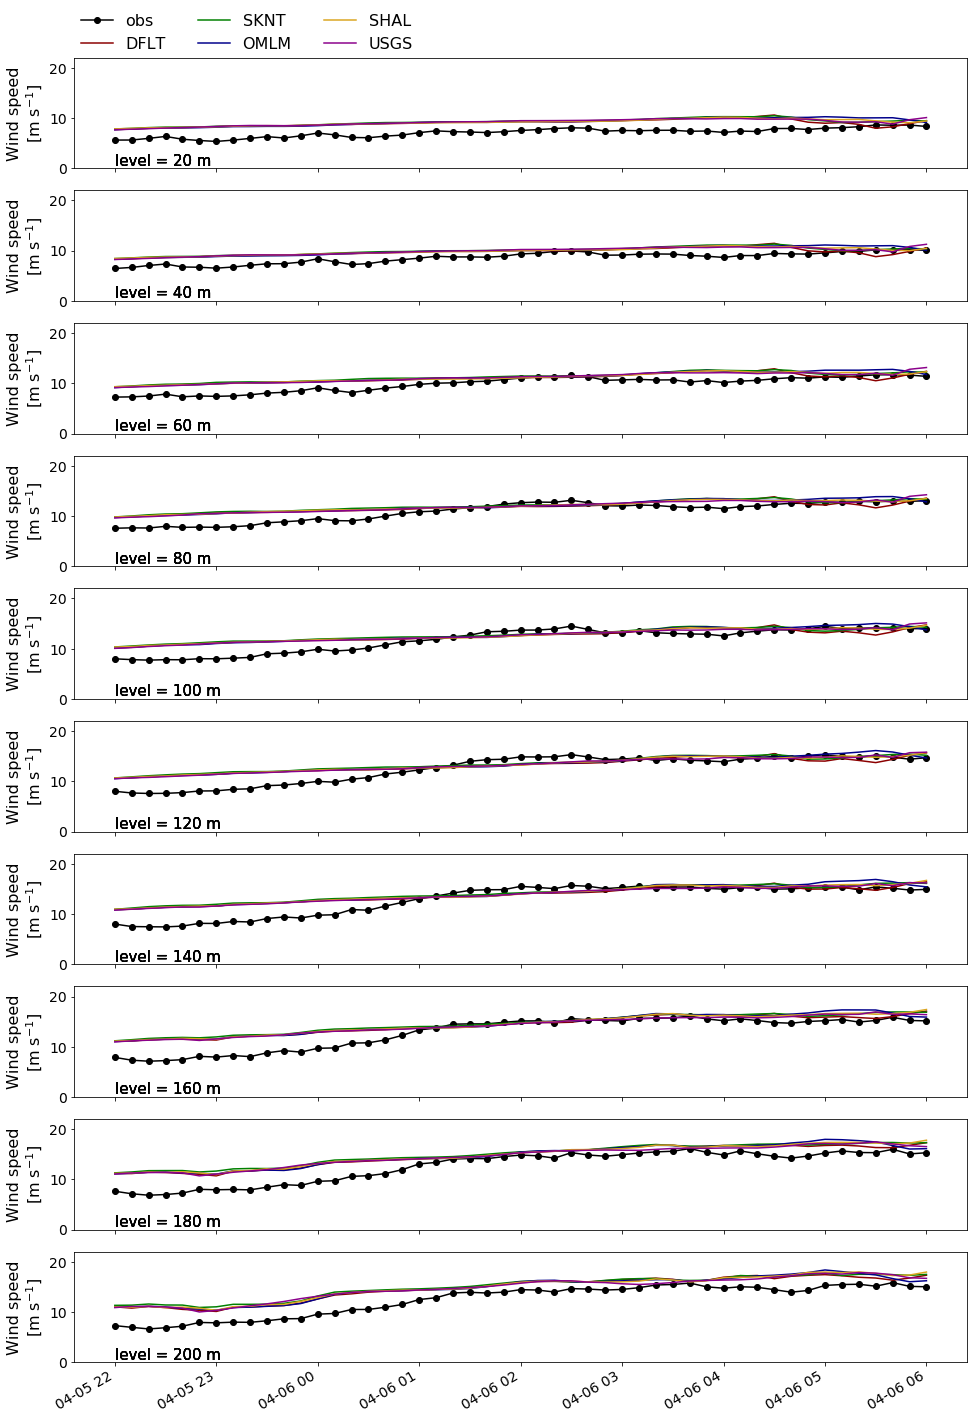

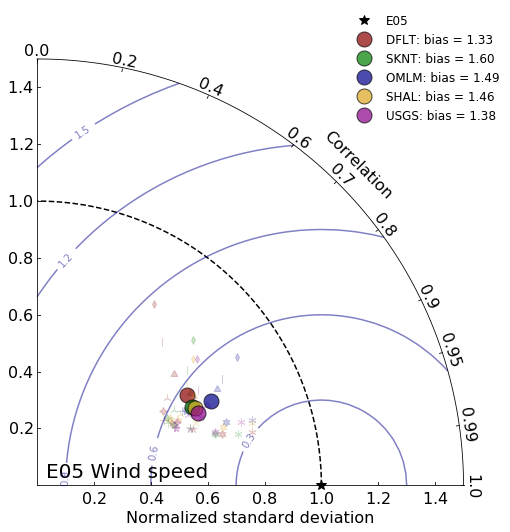

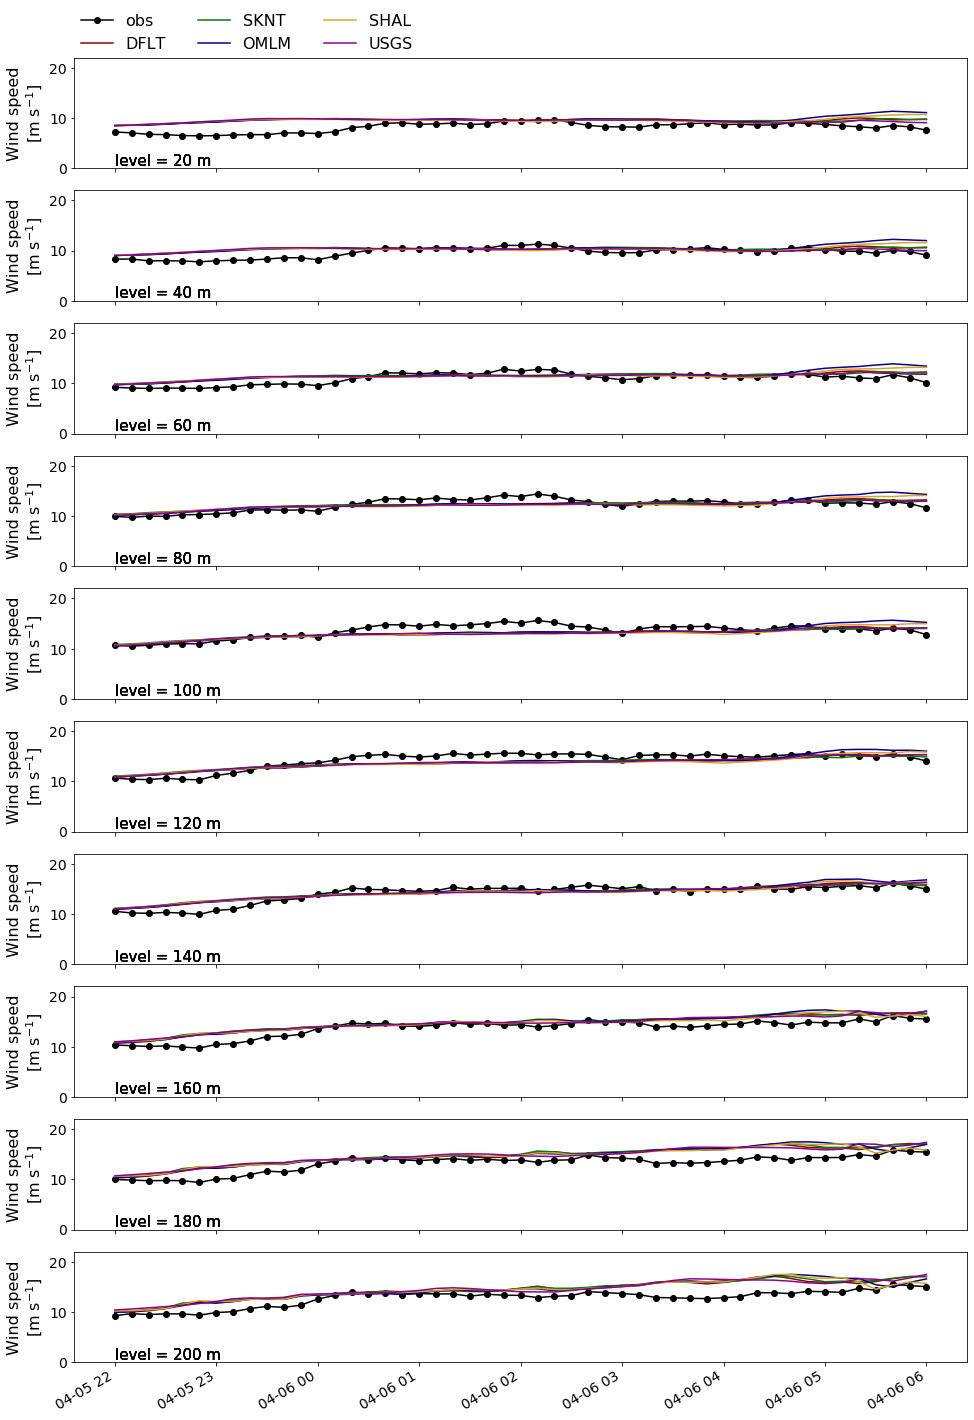

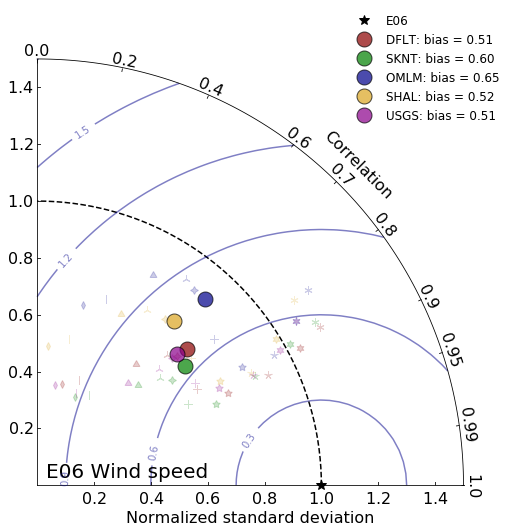

In [34]:
ncases = len(cases_of_interest)

td_start = '2020-04-05 22:00:00'
td_end   = '2020-04-06 06:00:00'
for dd,lid in enumerate(nyserda_obs.lidar.data):
    for TD_var in ['wspd']:
        obs_ds = nyserda_obs.sel(datetime=slice(td_start,td_end),lidar=lid)
        
        if TD_var == 'wspd':
            levels = obs_ds.Ulevels.values
            obs_wdir = obs_ds.wspd
            max_pts = 0
            dir_lvl = 0
            good_levels = []
            for vv,lvl in enumerate(obs_wdir.Ulevels.values):
                dir_lvl = obs_wdir.sel(Ulevels=lvl).dropna(how='all',dim='datetime')
                num_pts = len(dir_lvl)
                if num_pts > max_pts:
                    good_levels.append(lvl)
            plt_y_label = 'Wind speed\n[m s$^{-1}$]'
            plt_str     = '{} Wind speed'.format(lid)
            plt_y_min = 0.0
            plt_y_max = 22.0

        tay_obs_levels = [[[]]*len(good_levels)][0]
        rms_levels = np.zeros((ncases,len(good_levels)))
        ref_std_levels = np.zeros((ncases,len(good_levels)))
        sim_std_levels = np.zeros((ncases,len(good_levels)))
        sim_cor_levels = np.zeros((ncases,len(good_levels)))
        sim_bia_levels = np.zeros((ncases,len(good_levels)))
        fig,ax = plt.subplots(nrows=len(good_levels),figsize=(16,24),sharex=True)
        for cc,case in enumerate(cases_of_interest):
            twr_ds = wrf_data[case].sel(station=lid,datetime=slice(td_start,td_end))
            wrf_levels = twr_ds.ph.mean(dim='datetime')
            tay_wrf_levels = [[[]]*len(levels)][0]

            for vv,lvl in enumerate(good_levels):
                
                if TD_var == 'wspd':
                    tay_obs_levels[vv] = obs_ds.wspd.sel(Ulevels=lvl).dropna(how='all',dim='datetime')#.resample(
                                                         #datetime='10min').interpolate('linear')
                
                level_dist = abs(wrf_levels - lvl)
                wrf_lvl_ind = int(np.where(level_dist == np.nanmin(level_dist))[0])
                if (level_dist[wrf_lvl_ind] <= 10.0):
                    if TD_var == 'wspd':
                        tay_wrf_levels[vv] = twr_ds.wspd.sel(nz=wrf_lvl_ind).dropna(
                                                    how='all',dim='datetime').resample(datetime='10min').mean()

                obs = tay_obs_levels[vv]
                sim = tay_wrf_levels[vv]

                sim[np.where(np.isnan(obs))] = np.nan
                obs = obs.dropna(dim='datetime',how='all')
                sim = sim.dropna(dim='datetime',how='all')

                if len(obs) != len(sim):
                    sim = sim.sel(datetime=slice(obs.datetime[0],obs.datetime[-1]))

                ax[vv].text(obs.datetime.data[0],1.1*plt_y_min,'level = {} m'.format(lvl),va='bottom',size=15,ha='left')

                if cc == 0: 
                    obs.resample(datetime='10min').asfreq().plot(ax=ax[vv],c='k',label='obs',marker='o')
                sim.resample(datetime='10min').asfreq().plot(ax=ax[vv],
                                                             c=case_dict[case]['color'],
                                                             label=case_dict[case]['case_name'])
                ax[vv].tick_params(labelsize=14)
                if vv == len(levels)-1:
                    ax[vv].set_xlabel('Datetime',size=16)
                else:
                    ax[vv].set_xlabel('')
                ax[vv].set_title('')
                ax[vv].set_ylabel(plt_y_label,size=16)
                ref_std_levels[cc,vv] = np.std(obs.data)
                sim_std_levels[cc,vv] = np.std(sim.data)
                sim_cor_levels[cc,vv],_ = pearsonr(sim, obs)
                sim_bia_levels[cc,vv] = np.mean(sim-obs)
                rms_levels[cc,vv] = (sim_std_levels[cc,vv]/ref_std_levels[cc,vv])**2 + 1.0 - \
                                    2.0*sim_cor_levels[cc,vv]*(sim_std_levels[cc,vv]/ref_std_levels[cc,vv])
                rms_levels[cc,vv] = (np.sqrt(np.mean( ((sim.data-np.mean(sim.data)) - (obs.data-np.mean(obs.data)))**2 )) / \
                                     ref_std_levels[cc,vv])**2.0
                ax[vv].set_ylim(plt_y_min,plt_y_max)
                
                
        ax[0].legend(frameon=False,loc=(0.0,1.0),ncol=3,fontsize=16)
        #save_str = '{}/img/TD_data_{}'.format(wrf_dir,lid)
        #if save_figs: plt.savefig('{}.png'.format(save_str))
        plt.show()
        


        fig_tay = plt.figure(figsize=(8,8))  
        if TD_var == 'wspd':
            srange=[0.0,1.5]
            stdevticks=np.arange(0.2,5.6,0.2)
            extend_TD = False

        dia = TaylorDiagram(1.0, fig=fig_tay, 
                            extend=extend_TD,
                            label=lid,
                            normalize=True,
                            srange=srange,
                            stdevticks=stdevticks,
                            labelsize=16)

        td_stats = {}
        for cc,case in enumerate(cases_of_interest):
        #for cc,case in enumerate(cases):
            td_stats[case] = pd.DataFrame(index=levels, columns=['std_norm','R2'], dtype=float) 

            markers = [(i,j,0) for i in range(2,len(good_levels)+2) for j in range(1, 3)]

            for vv,lvl in enumerate(good_levels):
                td_stats[case].loc[lvl,'std_norm'] = sim_std_levels[cc,vv]/ref_std_levels[cc,vv]
                td_stats[case].loc[lvl,'R2'] = sim_cor_levels[cc,vv]

                dia.set_ref(ref_std_levels[cc,vv])
                if cc == 0:
                    label_str = '{}'.format(lvl)
                else:
                    label_str = None
                dia.add_sample(sim_std_levels[cc,vv], sim_cor_levels[cc,vv],
                               #marker=case_dict[case]['marker'], 
                               marker=markers[vv], 
                               ms=8, ls='',
                               mfc=case_dict[case]['color'], 
                               mec=case_dict[case]['color'], # Colors
                               #label=label_str,
                               zorder=cc,alpha=0.2)
            #plt.text(0.01,0.01+0.04*cc,case,color=case_dict[case]['d03']['color'],ha='left',va='bottom',size=16)
            td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
            td_mean = td_stats[case].mean(axis=0)
            dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                   norm=False, # don't normalize this point
                   #marker=case_dict[case]['marker'], 
                   marker='o', 
                   ms=15, ls='',
                   mfc=case_dict[case]['color'], mec='k', # Colors
                   label=case_dict[case]['case_name'] + ': bias = {0:3.2f}'.format(np.mean(sim_bia_levels[cc,:])),
                   zorder=cc+3,alpha=0.7)
        contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        if extend_TD:
            leg_loc = (0.2,0.8)
            leg_ncol = 3
        else:
            if case_selection == 'SST':
                leg_loc = (0.68,0.71)
            elif case_selection == 'SFC':
                leg_loc = (0.68,0.76)
            elif case_selection == 'LANDUSE':
                leg_loc = (0.68,0.81)
            else:
                leg_loc = (0.64,0.75)
                

            leg_ncol = 1
        fig_tay.legend(frameon=False,loc=leg_loc,fontsize=12,ncol=leg_ncol)
        #save_str = '{}/img/TD_FINO{}'.format(wrf_dir,fino)
        #if save_figs: plt.savefig('{}.png'.format(save_str))
        plt.text(0.03,0.03,plt_str,size=20)
        plt.show()
        

# Ensemble mean / spread:

In [35]:
def ensemble_statistics(ds,
                        variables=None,
                        observation_key='obs',
                        members_dim=None):

    if members_dim is None:
        raise ValueError ('Must specify dimension that defines the members (members_dim)')
    else:
        members = list(ds[members_dim].data)
        members.remove(observation_key)
        
    if variables is None:
        variables = list(ds.variables)
        for coord in list(ds.coords):
            variables.remove(coord)

    for varn in variables:
        data = ds[varn].sel({members_dim:members})
        ens_mean = data.mean(dim=members_dim)
        ens_mean_str = 'ens_mean_{}'.format(varn)
        ens_mean.name = ens_mean_str
        ds[ens_mean_str] = ens_mean
        
        ens_spread = (((data - ens_mean)**2).mean(dim=members_dim))**0.5
        ens_spread_str = 'ens_spread_{}'.format(varn)
        ens_spread.name = ens_spread_str
        ds[ens_spread_str] = ens_spread
        
        ens_error = ((ds[varn].sel({members_dim:observation_key}) - ens_mean)**2)**0.5
        ens_error_str = 'ens_error_{}'.format(varn)
        ens_error.name = ens_error_str
        ds[ens_error_str] = ens_error
        
    return(ds)

In [36]:
ens_ds = data_ds.sel(case=cases_of_interest + ['obs']).copy()
delT = ens_ds.t2 - ens_ds.sst
delT.name = 'delT'
ens_ds['delT'] = delT

max_wspd = ens_ds.wspd.max(dim='level')
max_wspd.name = 'max_wspd'
ens_ds['max_wspd'] = max_wspd

hub_wspd = ens_ds.wspd.sel(level=120)
hub_wspd.name = 'hub_wspd'
ens_ds['hub_wspd'] = hub_wspd
print(ens_ds)

<xarray.Dataset>
Dimensions:    (case: 6, datetime: 85, level: 10, lidar: 2)
Coordinates:
  * case       (case) object 'MERRA2_DFLT_NOSK_CHRN_MDIS' ... 'obs'
  * lidar      (lidar) object 'E05' 'E06'
  * level      (level) int64 20 40 60 80 100 120 140 160 180 200
  * datetime   (datetime) datetime64[ns] 2020-04-05T16:00:00 ... 2020-04-06T06:00:00
    lon        float64 ...
    lat        float64 ...
Data variables:
    wspd       (level, case, lidar, datetime) float64 3.892 4.039 ... 15.07
    wrf_level  (level, case, lidar) float64 ...
    sst        (case, lidar, datetime) float64 ...
    t2         (case, lidar, datetime) float64 ...
    delT       (case, lidar, datetime) float64 0.09819 0.1117 0.125 ... 0.9 0.82
    max_wspd   (case, lidar, datetime) float64 5.014 5.196 5.359 ... 15.68 15.5
    hub_wspd   (case, lidar, datetime) float64 4.607 4.819 5.038 ... 14.87 14.06


In [37]:
# Not sure if there's a better way than looping... but loop to find LLJ height:
llj_height = np.zeros(np.shape(ens_ds.t2))

for tt,time in enumerate(ens_ds.datetime):
    wind_profile = ens_ds.sel(datetime=time).wspd
    for cc,case in enumerate(ens_ds.case.data):
        for ll,lid in enumerate(ens_ds.lidar.data):
            wind_profile = ens_ds.sel(datetime=time,case=case,lidar=lid).wspd
            height_profile = ens_ds.sel(datetime=time,case=case,lidar=lid).wrf_level
            if case == 'obs':
                llj_height[cc,ll,tt] = ens_ds.level[np.where(wind_profile==wind_profile.max())].data[0]                
            else:
                llj_height[cc,ll,tt] = height_profile[np.where(wind_profile==wind_profile.max())].data[0]

llj_height_da = xr.DataArray(
                            data=llj_height,
                            dims=['case', 'lidar', 'datetime'],
                            coords=dict(
                                case=ens_ds.case.data,
                                lidar=ens_ds.lidar.data,
                                datetime=ens_ds.datetime.data,
                            ),
                        )
ens_ds['llj_height'] = llj_height_da

In [38]:
ens_ds = ensemble_statistics(ens_ds,members_dim='case')

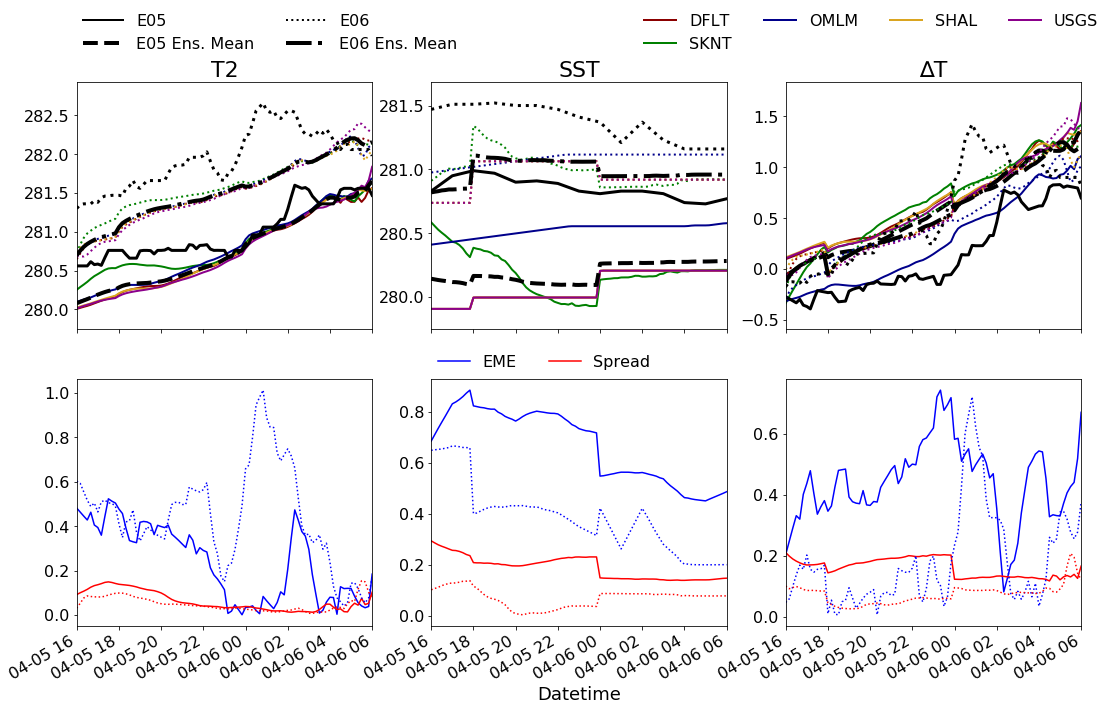

In [39]:
variables = ['t2','sst','delT']

plt_start = ens_ds.datetime[0].data
plt_end = ens_ds.datetime[-1].data

fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(6*len(variables),10),sharex=True)

for ll,lid in enumerate(ens_ds.lidar):
    if ll == 0:
        ls = '-'
        mean_ls = '--'
    else:
        ls = ':'
        mean_ls = '-.'
        

    for vv,varn in enumerate(variables):
        for cc,case in enumerate(cases_of_interest):
            if (ll == 0) and (vv == 2):
                plt_lbl = case_dict[case]['case_name']
            else:
                plt_lbl = None
            ens_ds.sel(case=case,lidar=lid)[varn].plot(ax=ax[0,vv],c=case_dict[case]['color'],ls=ls,lw=2.0,label=plt_lbl)
        ens_ds['ens_mean_{}'.format(varn)].sel(lidar=lid).plot(c='k',lw=4.0,ax=ax[0,vv],ls=mean_ls,alpha=1.0)
        ens_ds.sel(case='obs')[varn].sel(lidar=lid).plot(ax=ax[0,vv],c='k',ls=ls,lw=3.0)
        
        if ll == 0:
            err_str  = 'EME'
            sprd_str = 'Spread'
        else:
            err_str,sprd_str = None,None
        ens_ds['ens_error_{}'.format(varn)].sel(lidar=lid).plot(c='b',ax=ax[1,vv],label=err_str,ls=ls)
        ens_ds['ens_spread_{}'.format(varn)].sel(lidar=lid).plot(c='r',ax=ax[1,vv],label=sprd_str,ls=ls)
        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            ax[axi,vv].set_ylabel('')
            ax[axi,vv].set_xlabel('')

        var_min = ens_ds[varn].min()
        var_max = ens_ds[varn].max()
        var_range = var_max - var_min
        ax[0,vv].set_ylim(var_min - var_range*0.1,var_max + var_range*0.1)
        if varn == 'delT':
            var_str = '∆T'
        else:
            var_str = varn.upper()
        ax[0,vv].set_title(var_str,size=22)
        ax[1,vv].set_title('')        

        if vv == 0:
            ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='k',ls=ls,label=str(lid.data),lw=2.0)
            ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='k',ls=mean_ls,label=str(lid.data)+' Ens. Mean',lw=4.0)

        
ax[0,0].set_xlim(plt_start,plt_end)
ax[1,1].set_xlabel('Datetime',size=18)

ax[0,0].legend(loc=(0.0,1.1),frameon=False,ncol=2,fontsize=16,handlelength=2.5)
ax[1,1].legend(frameon=False,loc=(0.0,1.01),fontsize=16,ncol=2)
ax[0,2].legend(frameon=False,loc=(-0.5,1.1),ncol=4,fontsize=16)
plt.show()


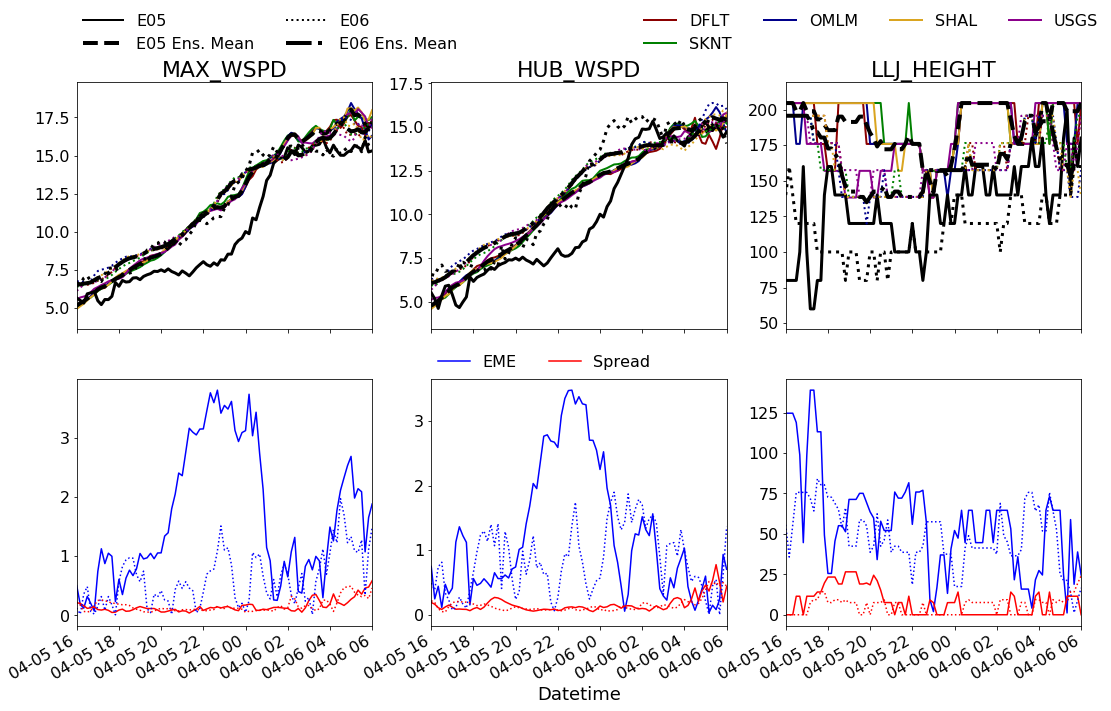

In [40]:
variables = ['max_wspd','hub_wspd','llj_height']

plt_start = ens_ds.datetime[0].data
plt_end = ens_ds.datetime[-1].data

fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(6*len(variables),10),sharex=True)

for ll,lid in enumerate(ens_ds.lidar):
    if ll == 0:
        ls = '-'
        mean_ls = '--'
    else:
        ls = ':'
        mean_ls = '-.'
        

    for vv,varn in enumerate(variables):
        for cc,case in enumerate(cases_of_interest):
            if (ll == 0) and (vv == 2):
                plt_lbl = case_dict[case]['case_name']
            else:
                plt_lbl = None
            ens_ds.sel(case=case,lidar=lid)[varn].plot(ax=ax[0,vv],c=case_dict[case]['color'],ls=ls,lw=2.0,label=plt_lbl)
        ens_ds['ens_mean_{}'.format(varn)].sel(lidar=lid).plot(c='k',lw=4.0,ax=ax[0,vv],ls=mean_ls,alpha=1.0)
        ens_ds.sel(case='obs')[varn].sel(lidar=lid).plot(ax=ax[0,vv],c='k',ls=ls,lw=3.0)
        
        if ll == 0:
            err_str  = 'EME'
            sprd_str = 'Spread'
        else:
            err_str,sprd_str = None,None
        ens_ds['ens_error_{}'.format(varn)].sel(lidar=lid).plot(c='b',ax=ax[1,vv],label=err_str,ls=ls)
        ens_ds['ens_spread_{}'.format(varn)].sel(lidar=lid).plot(c='r',ax=ax[1,vv],label=sprd_str,ls=ls)
        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            ax[axi,vv].set_ylabel('')
            ax[axi,vv].set_xlabel('')

        var_min = ens_ds[varn].min()
        var_max = ens_ds[varn].max()
        var_range = var_max - var_min
        ax[0,vv].set_ylim(var_min - var_range*0.1,var_max + var_range*0.1)
        if varn == 'delT':
            var_str = '∆T'
        else:
            var_str = varn.upper()
        ax[0,vv].set_title(var_str,size=22)
        ax[1,vv].set_title('')        

        if vv == 0:
            ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='k',ls=ls,label=str(lid.data),lw=2.0)
            ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='k',ls=mean_ls,label=str(lid.data)+' Ens. Mean',lw=4.0)

        
ax[0,0].set_xlim(plt_start,plt_end)
ax[1,1].set_xlabel('Datetime',size=18)

ax[0,0].legend(loc=(0.0,1.1),frameon=False,ncol=2,fontsize=16,handlelength=2.5)
ax[1,1].legend(frameon=False,loc=(0.0,1.01),fontsize=16,ncol=2)
ax[0,2].legend(frameon=False,loc=(-0.5,1.1),ncol=4,fontsize=16)
plt.show()


# Ensemble statistics for wind speed:

In [41]:
periods_s = ['2020-04-06 02:00:00','2020-04-06 03:00:00']
periods_e = ['2020-04-06 03:00:00','2020-04-06 04:00:00']

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


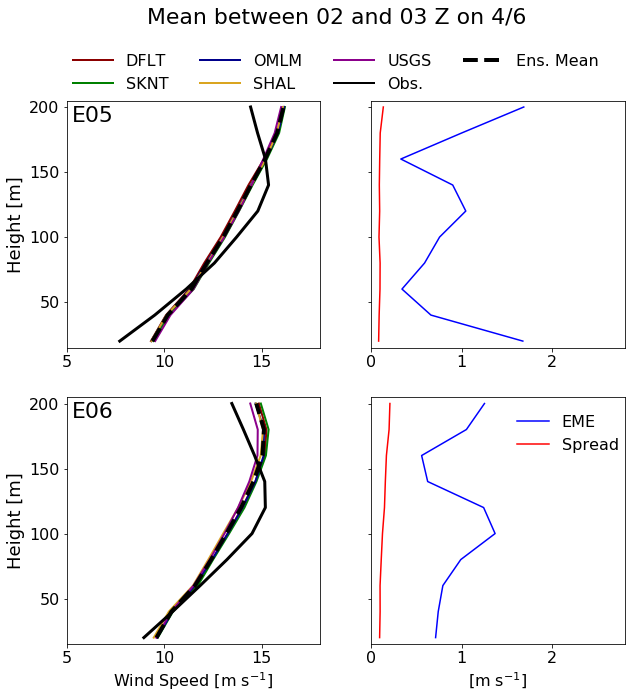

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


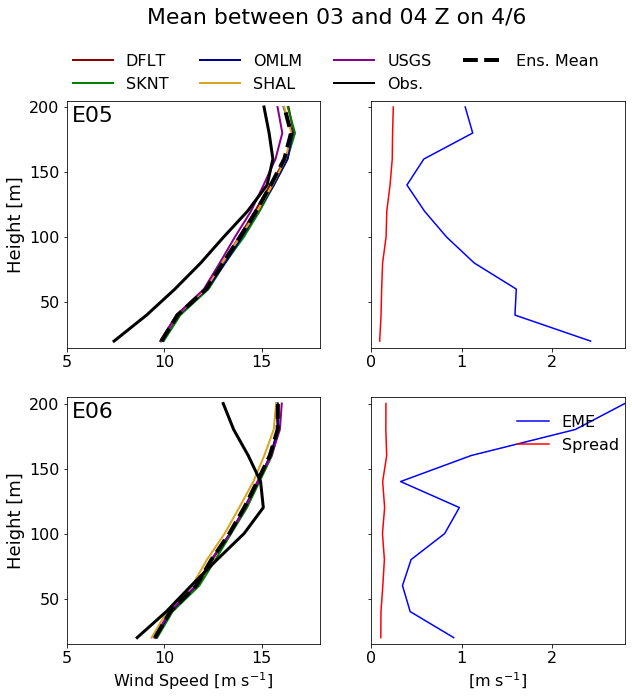

In [42]:
for period_s,period_e in zip(periods_s,periods_e):
# Pick the time period of interest and average statistics over this period?
    plt_start = pd.to_datetime(period_s)
    plt_end = pd.to_datetime(period_e)

    data_toi = ens_ds.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime')

    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10),sharey=True)


    varn = 'wspd'
    for ll,lid in enumerate(ens_ds.lidar):
        ls = '-'
        mean_ls = '--'

        for cc,case in enumerate(cases_of_interest):
            if (ll == 0):
                plt_lbl = case_dict[case]['case_name']
            else:
                plt_lbl = None
            data_toi.sel(case=case,lidar=lid)[varn].plot(y='level',ax=ax[ll,0],c=case_dict[case]['color'],ls=ls,lw=2.0,label=plt_lbl)

        data_toi['ens_mean_{}'.format(varn)].sel(lidar=lid).plot(y='level',c='k',lw=4.0,ax=ax[ll,0],ls=mean_ls,alpha=1.0)
        data_toi.sel(case='obs')[varn].sel(lidar=lid).plot(y='level',ax=ax[ll,0],c='k',ls=ls,lw=3.0)

        err_str  = 'EME'
        sprd_str = 'Spread'

        data_toi['ens_error_{}'.format(varn)].sel(lidar=lid).plot(y='level',c='b',ax=ax[ll,1],label=err_str,ls=ls)
        data_toi['ens_spread_{}'.format(varn)].sel(lidar=lid).plot(y='level',c='r',ax=ax[ll,1],label=sprd_str,ls=ls)
        for axi in range(0,2):
            ax[ll,axi].tick_params(labelsize=16)
            ax[ll,axi].set_ylabel('')
            ax[ll,axi].set_xlabel('')
            ax[ll,axi].set_title('')

        var_min = ens_ds[varn].min()
        var_max = ens_ds[varn].max()
        var_range = var_max - var_min
        #ax[ll,0].set_xlim(var_min - var_range*0.1,var_max + var_range*0.1)
        var_min,var_max = 5,18
        ax[ll,0].set_xlim(var_min,var_max)
        if varn == 'delT':
            var_str = '∆T'
        else:
            var_str = varn.upper()
        ax[ll,0].text(0.02,0.98,lid.data,size=22,va='top',transform=ax[ll,0].transAxes)

        ax[ll,0].plot([-10,-11],[1,1],c='k',ls=ls,label='Obs.',lw=2.0)
        ax[ll,0].plot([-10,-11],[1,1],c='k',ls=mean_ls,label='Ens. Mean',lw=4.0)

        ax[ll,0].set_ylabel('Height [m]',size=18)
        ax[ll,1].set_xlim(0,2.8)

    ax[1,0].set_xlabel('Wind Speed [m s$^{-1}$]',size=16)
    ax[1,1].set_xlabel('[m s$^{-1}$]',size=16)
    ax[0,0].set_ylim(15,205)

    ax[0,0].legend(loc=(0.0,1.01),frameon=False,ncol=4,fontsize=16,handlelength=2.5)
    ax[1,1].legend(frameon=False,loc=(0.55,0.75),fontsize=16,ncol=1)
    plt.suptitle('Mean between {0:02d} and {1:02d} Z on {2}/{3}'.format(plt_start.hour,plt_end.hour,plt_start.month,plt_start.day),
                 y=1.01,size=22)
    plt.show()

### EME vs Spread for time series variables averaged over the POI:

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


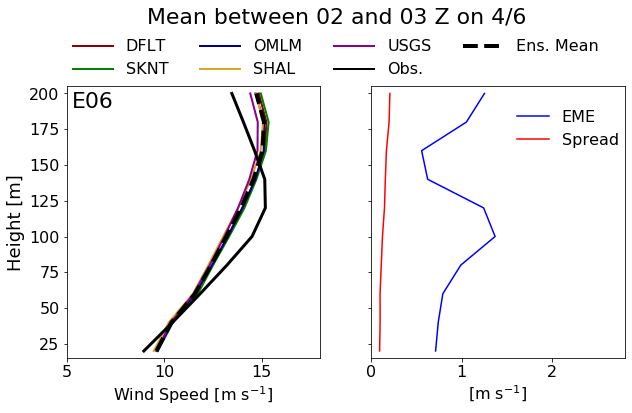

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


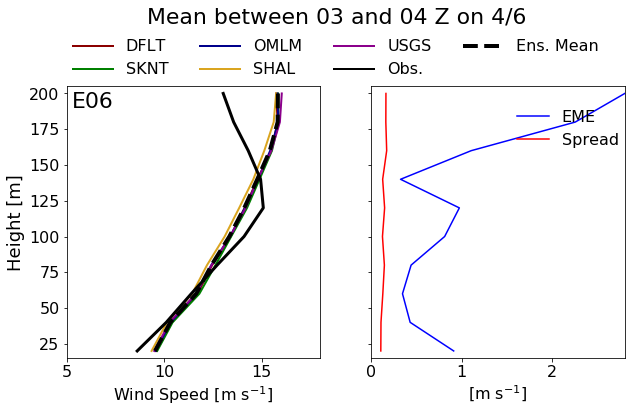

In [44]:
for period_s,period_e in zip(periods_s,periods_e):
# Pick the time period of interest and average statistics over this period?
    plt_start = pd.to_datetime(period_s)
    plt_end = pd.to_datetime(period_e)

    data_toi = ens_ds.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime')

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharey=True)


    varn = 'wspd'
    for ll,lid in enumerate(ens_ds.lidar[1:]):
        ls = '-'
        mean_ls = '--'

        for cc,case in enumerate(cases_of_interest):
            if (ll == 0):
                plt_lbl = case_dict[case]['case_name']
            else:
                plt_lbl = None
            data_toi.sel(case=case,lidar=lid)[varn].plot(y='level',ax=ax[0],c=case_dict[case]['color'],ls=ls,lw=2.0,label=plt_lbl)

        data_toi['ens_mean_{}'.format(varn)].sel(lidar=lid).plot(y='level',c='k',lw=4.0,ax=ax[0],ls=mean_ls,alpha=1.0)
        data_toi.sel(case='obs')[varn].sel(lidar=lid).plot(y='level',ax=ax[0],c='k',ls=ls,lw=3.0)

        err_str  = 'EME'
        sprd_str = 'Spread'

        data_toi['ens_error_{}'.format(varn)].sel(lidar=lid).plot(y='level',c='b',ax=ax[1],label=err_str,ls=ls)
        data_toi['ens_spread_{}'.format(varn)].sel(lidar=lid).plot(y='level',c='r',ax=ax[1],label=sprd_str,ls=ls)
        for axi in range(0,2):
            ax[axi].tick_params(labelsize=16)
            ax[axi].set_ylabel('')
            ax[axi].set_xlabel('')
            ax[axi].set_title('')

        var_min = ens_ds[varn].min()
        var_max = ens_ds[varn].max()
        var_range = var_max - var_min
        #ax[0].set_xlim(var_min - var_range*0.1,var_max + var_range*0.1)
        var_min,var_max = 5,18
        ax[0].set_xlim(var_min,var_max)
        if varn == 'delT':
            var_str = '∆T'
        else:
            var_str = varn.upper()
        ax[0].text(0.02,0.98,lid.data,size=22,va='top',transform=ax[0].transAxes)

        ax[0].plot([-10,-11],[1,1],c='k',ls=ls,label='Obs.',lw=2.0)
        ax[0].plot([-10,-11],[1,1],c='k',ls=mean_ls,label='Ens. Mean',lw=4.0)

        ax[0].set_ylabel('Height [m]',size=18)
        ax[1].set_xlim(0,2.8)

    ax[0].set_xlabel('Wind Speed [m s$^{-1}$]',size=16)
    ax[1].set_xlabel('[m s$^{-1}$]',size=16)
    ax[0].set_ylim(15,205)

    ax[0].legend(loc=(0.0,1.01),frameon=False,ncol=4,fontsize=16,handlelength=2.5)
    ax[1].legend(frameon=False,loc=(0.55,0.75),fontsize=16,ncol=1)
    if case_selection == 'SST':
        title_y = 1.16
    elif case_selection == 'SFC':
        title_y = 1.1
    plt.suptitle('Mean between {0:02d} and {1:02d} Z on {2}/{3}'.format(plt_start.hour,plt_end.hour,plt_start.month,plt_start.day),
                 y=title_y,size=22)
    plt.show()

# WRF 2D Comparisons:

In [17]:
wrfout_files = sorted(glob.glob('{}{}/wrfout_d02*'.format(main_directory,cases[0])))
wrfouts_of_interest = {}
for ff,filen in enumerate(wrfout_files):
    wrf_time = pd.to_datetime(filen.split('/')[-1].split('d02_')[-1].replace('_',' '))
    if wrf_time >= pd.to_datetime(case_start):
        wrfouts_of_interest[filen.split('/')[-1]] = wrf_time

wrfout = xr.open_dataset(wrfout_files[0])
wrf_lat = wrfout.XLAT.squeeze()
wrf_lon = wrfout.XLONG.squeeze()
landmask = wrfout.LANDMASK.squeeze()

shalwater = xr.open_dataset('{}MERRA2_DFLT_NOSK_SHAL_MDIS/wrfinput_d02'.format(main_directory)).squeeze()
water_depth = shalwater.WATER_DEPTH

# Mean Impacts:

In [18]:
def get_mean_quantities(cases,wrfout_file_list,main_directory,variables,levels=None):
    init_means = True
    get_water_depth = True

    mean_vars = {}
    for vv,varn in enumerate(variables):
        mean_vars[varn] = {}
        
    count = 0
    for tt,wrf_time in enumerate(wrfout_file_list):
        for cc,case in enumerate(cases):
            
            case_dir = '{}{}/'.format(main_directory,case)
            wrfout = xr.open_dataset('{}{}'.format(case_dir,wrf_time),decode_times=False).sel(Time=0)

            for vv,varn in enumerate(variables):
                if varn == 'wspd':
                    if levels is None:
                        varoi = (wrfout.U10**2 + wrfout.V10**2)**0.5
                    else:
                        u = wrfout.U.sel(bottom_top=levels)
                        v = wrfout.V.sel(bottom_top=levels)
                        u = 0.5*(u[:,:,1:] + u[:,:,:-1])
                        v = 0.5*(v[:,1:,:] + v[:,:-1,:])
                        u = u.rename({'west_east_stag':'west_east'})
                        v = v.rename({'south_north_stag':'south_north'})
                        varoi = (u**2 + v**2)**0.5
                else:
                    varoi = wrfout[varn]
                    if len(np.shape(varoi)) > 2:
                        if levels is not None:
                            if 'bottom_top' in varoi.dims:
                                varoi = varoi.sel(bottom_top=levels)
                            elif 'bottom_top_stag' in varoi.dims:
                                varoi = varoi.sel(bottom_top_stag=levels)
                        else:
                            raise ValueError('Dimensions are greater than 2... specify levels.')

                if init_means:
                    mean_vars[varn][case] = varoi
                else:
                    mean_vars[varn][case] += varoi
        init_means = False
        count += 1

    for case in cases:
        for vv,varn in enumerate(variables):
            mean_vars[varn][case] /= count
    return(mean_vars)

# Gravity Wave Check:

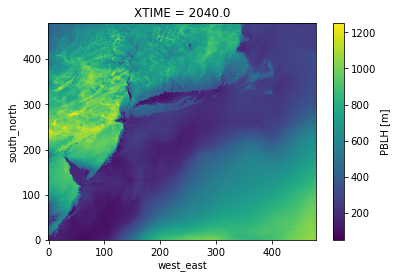

In [19]:
case_of_interest = 'MERRA2_DFLT_NOSK_CHRN_MDIS'
avg_pbl = get_mean_quantities([case_of_interest],list(wrfouts_of_interest.keys()),main_directory,['PBLH'])
avg_pbl['PBLH'][case_of_interest].plot()

z = ((wrfout.PH + wrfout.PHB)/9.81).mean(dim=['south_north','west_east']).squeeze()

In [20]:
heights_of_interest = [500,1000,2000]
height_oi_ind = []
for zz in heights_of_interest:
    dist = np.asarray(((z - zz)**2)**0.5)
    height_oi_ind.append(int(np.where(dist == np.nanmin(dist))[0]))

In [21]:
mean_vars = get_mean_quantities([case_of_interest],list(wrfouts_of_interest.keys())[-6:],main_directory,['wspd','W'],levels=height_oi_ind)

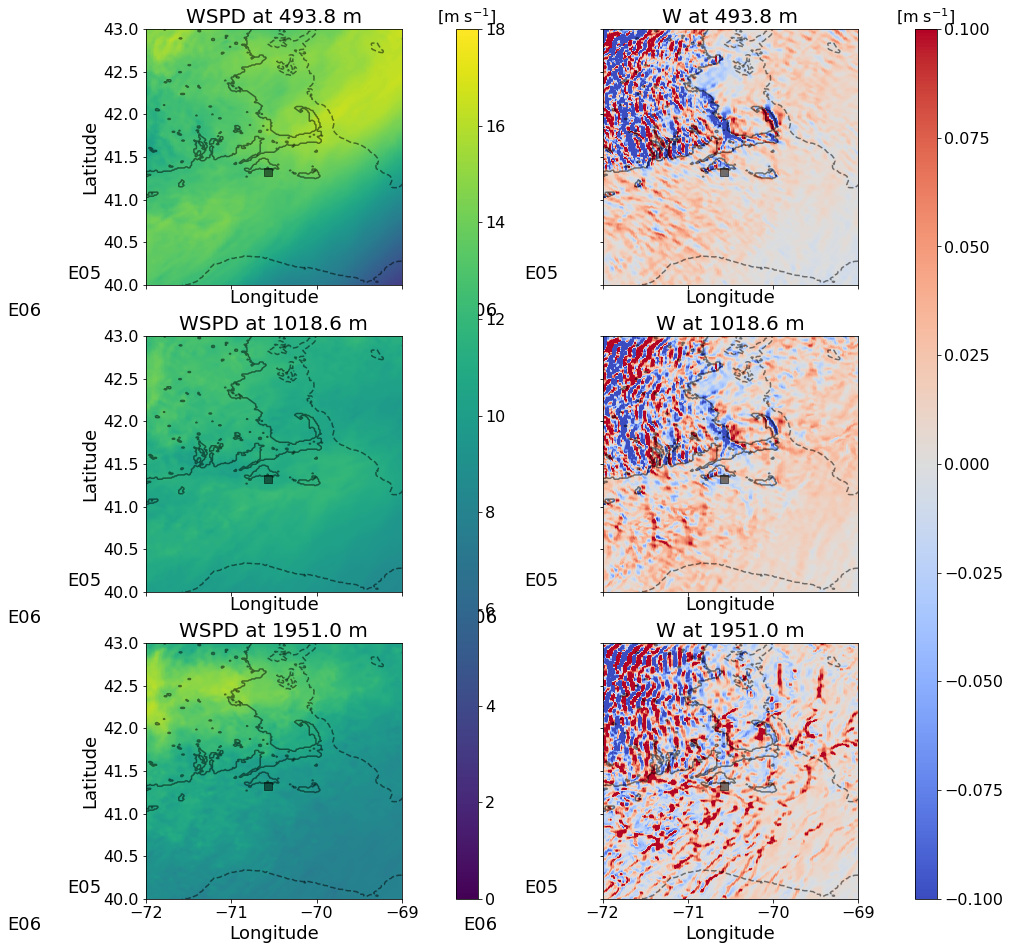

In [22]:
fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(15,16),sharey=True,sharex=True)

var_dict = {'wspd' : {'dval':18},
             'ZNT' : {'dval':2e-4},
               'W' : {'dval':0.1},
             'UST' : {'dval':2e-2},
              'T2' : {'dval':0.1},
           }

vars_of_interest = ['wspd','W']

for ll,lvl in enumerate(height_oi_ind):
    for vv,varn in enumerate(vars_of_interest):
        dval = var_dict[varn]['dval']
        if varn == 'wspd':
            norm = Normalize(0,dval)
            cmap = plt.cm.viridis
        else:
            norm = Normalize(-dval,dval)
            cmap = plt.cm.coolwarm
        dvar = mean_vars[varn][case_of_interest]

        if 'bottom_top' in dvar.dims:
            plt_var = dvar.sel(bottom_top=ll)
        elif 'bottom_top_stag' in dvar.dims:
            plt_var = dvar.sel(bottom_top_stag=ll)
        else:
            pltvar = dvar
        pcol = ax[ll,vv].pcolormesh(wrf_lon,wrf_lat,plt_var,
                                     norm=norm,cmap=cmap)
        ax[ll,vv].contour(wrf_lon,wrf_lat,landmask,levels=[0.5],colors='k',alpha=0.5)
        ax[ll,vv].contour(wrf_lon,wrf_lat,-water_depth,levels=[-100.0],colors='k',alpha=0.5)


        for ss,stn in enumerate(wrf_data[case].station):
            marker='s'
            marker_color = 'k'
            marker_a = 1.0
            if 'E0' in str(stn):
                marker_color = 'k'
            else:
                marker_color = 'k'
                marker_a = 0.5

            try:
                if np.isnan(marker_color):
                    marker_color = 'k'
            except:
                marker = marker

            ax[ll,vv].scatter([wrf_data[case].sel(station=stn).lon],
                           [wrf_data[case].sel(station=stn).lat],
                           marker=marker,s=80,ec='k',
                           alpha=marker_a,
                           c=[marker_color])
            if 'E0' in str(stn):
                ax[ll,vv].text(wrf_data[case].sel(station=stn).lon,
                            wrf_data[case].sel(station=stn).lat+0.05,
                            str(stn.data),size=18,ha='center',va='bottom')
        ax[ll,vv].set_title('{0} at {1:4.1f} m'.format(varn.upper(),float(z.sel(bottom_top_stag=lvl).data)),size=20)
        ax[ll,vv].tick_params(labelsize=16)
        if vv == 0: ax[ll,vv].set_ylabel('Latitude',size=18)
        ax[ll,vv].set_xlabel('Longitude',size=18)
        ax[ll,vv].set_aspect('equal')
        ax[ll,vv].set_ylim(40,43)
        ax[ll,vv].set_xlim(-72,-69)
        
        if ll == 1:
            cax  = fig.add_axes([0.47 + 0.425*vv,0.125,0.02,0.755])
            cbar = plt.colorbar(pcol,cax=cax)
            cbar.ax.tick_params(labelsize=16)
            if (varn == 'wspd') or (varn == 'W'):
                units = '[m s$^{-1}$]'
            else:
                units = ''
            cbar.ax.set_title(units,size=16)




# Shallow water comparison:

In [55]:
main_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/'

main_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/sfclay_opt_5/'

In [56]:
shal_cases = ['MERRA2_DFLT_NOSK_CHRN_MDIS','MERRA2_DFLT_NOSK_SHAL_MDIS']
mean_shal_vars = get_mean_quantities(shal_cases,list(wrfouts_of_interest.keys()),main_directory,['wspd','ZNT','T2','UST'])

lu_cases = ['MERRA2_DFLT_NOSK_CHRN_MDIS','MERRA2_DFLT_NOSK_CHRN_USGS']
mean_lu_vars = get_mean_quantities(lu_cases,list(wrfouts_of_interest.keys()),main_directory,['wspd','T2'])

Text(0.5, 1.01, 'SHAL - CHRN')

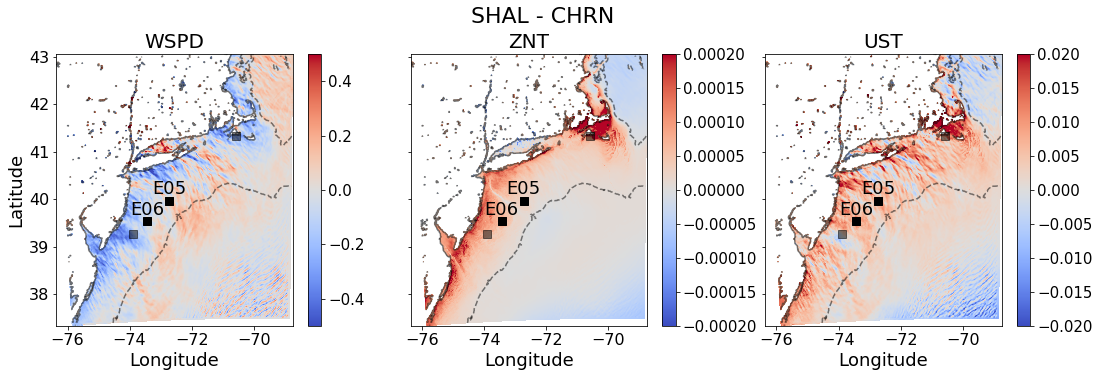

In [54]:
fig,ax = plt.subplots(ncols=3,figsize=(18,5),sharey=True)

var_dict = {'wspd' : {'dval':0.5},
             'ZNT' : {'dval':2e-4},
             'UST' : {'dval':2e-2},
              'T2' : {'dval':0.1},
           }

vars_of_interest = ['wspd','ZNT','UST']
for vv,varn in enumerate(vars_of_interest):
    dval = var_dict[varn]['dval']
    dvar = mean_shal_vars[varn][shal_cases[1]] - mean_shal_vars[varn][shal_cases[0]]
    pcol = ax[vv].pcolormesh(wrf_lon,wrf_lat,dvar.where(landmask==0.0),
                     norm=Normalize(-dval,dval),cmap=plt.cm.coolwarm)
    ax[vv].contour(wrf_lon,wrf_lat,landmask,levels=[0.5],colors='k',alpha=0.5)
    ax[vv].contour(wrf_lon,wrf_lat,-water_depth,levels=[-100.0],colors='k',alpha=0.5)
    
    for ss,stn in enumerate(wrf_data[case].station):
        marker='s'
        marker_color = 'k'
        marker_a = 1.0
        if 'E0' in str(stn):
            marker_color = 'k'
        else:
            marker_color = 'k'
            marker_a = 0.5

        try:
            if np.isnan(marker_color):
                marker_color = 'k'
        except:
            marker = marker

        ax[vv].scatter([wrf_data[case].sel(station=stn).lon],
                       [wrf_data[case].sel(station=stn).lat],
                       marker=marker,s=80,ec='k',
                       alpha=marker_a,
                       c=[marker_color])
        if 'E0' in str(stn):
            ax[vv].text(wrf_data[case].sel(station=stn).lon,
                        wrf_data[case].sel(station=stn).lat+0.05,
                        str(stn.data),size=18,ha='center',va='bottom')
    ax[vv].set_title(varn.upper(),size=20)
    ax[vv].tick_params(labelsize=16)
    if vv == 0: ax[vv].set_ylabel('Latitude',size=18)
    ax[vv].set_xlabel('Longitude',size=18)
    cbar = plt.colorbar(pcol,ax=ax[vv])
    cbar.ax.tick_params(labelsize=15)
plt.suptitle('SHAL - CHRN',size=22,y=1.01)

Text(0.5, 1.01, 'SHAL - CHRN')

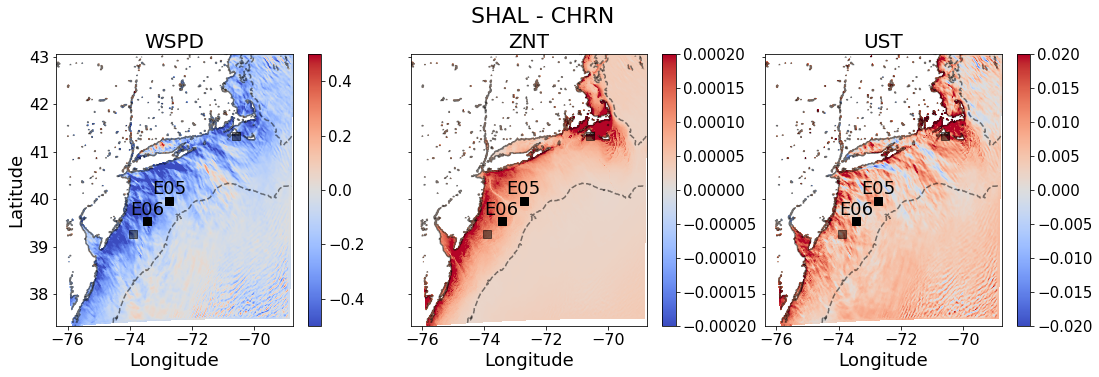

In [57]:
fig,ax = plt.subplots(ncols=3,figsize=(18,5),sharey=True)

var_dict = {'wspd' : {'dval':0.5},
             'ZNT' : {'dval':2e-4},
             'UST' : {'dval':2e-2},
              'T2' : {'dval':0.1},
           }

vars_of_interest = ['wspd','ZNT','UST']
for vv,varn in enumerate(vars_of_interest):
    dval = var_dict[varn]['dval']
    dvar = mean_shal_vars[varn][shal_cases[1]] - mean_shal_vars[varn][shal_cases[0]]
    pcol = ax[vv].pcolormesh(wrf_lon,wrf_lat,dvar.where(landmask==0.0),
                     norm=Normalize(-dval,dval),cmap=plt.cm.coolwarm)
    ax[vv].contour(wrf_lon,wrf_lat,landmask,levels=[0.5],colors='k',alpha=0.5)
    ax[vv].contour(wrf_lon,wrf_lat,-water_depth,levels=[-100.0],colors='k',alpha=0.5)
    
    for ss,stn in enumerate(wrf_data[case].station):
        marker='s'
        marker_color = 'k'
        marker_a = 1.0
        if 'E0' in str(stn):
            marker_color = 'k'
        else:
            marker_color = 'k'
            marker_a = 0.5

        try:
            if np.isnan(marker_color):
                marker_color = 'k'
        except:
            marker = marker

        ax[vv].scatter([wrf_data[case].sel(station=stn).lon],
                       [wrf_data[case].sel(station=stn).lat],
                       marker=marker,s=80,ec='k',
                       alpha=marker_a,
                       c=[marker_color])
        if 'E0' in str(stn):
            ax[vv].text(wrf_data[case].sel(station=stn).lon,
                        wrf_data[case].sel(station=stn).lat+0.05,
                        str(stn.data),size=18,ha='center',va='bottom')
    ax[vv].set_title(varn.upper(),size=20)
    ax[vv].tick_params(labelsize=16)
    if vv == 0: ax[vv].set_ylabel('Latitude',size=18)
    ax[vv].set_xlabel('Longitude',size=18)
    cbar = plt.colorbar(pcol,ax=ax[vv])
    cbar.ax.tick_params(labelsize=15)
plt.suptitle('SHAL - CHRN',size=22,y=1.01)